In [ ]:
! pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexpap1997","key":"2ef7a92c4921b38fe7d7731142dc29ce"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'jehanbhathena/weather-dataset'
!mkdir -p weather_dataset
!unzip weather-dataset -d weather_dataset

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: weather_dataset/dataset/frost/3913.jpg  
  inflating: weather_dataset/dataset/frost/3914.jpg  
  inflating: weather_dataset/dataset/frost/3915.jpg  
  inflating: weather_dataset/dataset/frost/3916.jpg  
  inflating: weather_dataset/dataset/frost/3917.jpg  
  inflating: weather_dataset/dataset/frost/3918.jpg  
  inflating: weather_dataset/dataset/frost/3919.jpg  
  inflating: weather_dataset/dataset/frost/3920.jpg  
  inflating: weather_dataset/dataset/frost/3921.jpg  
  inflating: weather_dataset/dataset/frost/3922.jpg  
  inflating: weather_dataset/dataset/frost/3923.jpg  
  inflating: weather_dataset/dataset/frost/3924.jpg  
  inflating: weather_dataset/dataset/frost/3925.jpg  
  inflating: weather_dataset/dataset/frost/3926.jpg  
  inflating: weather_dataset/dataset/frost/3927.jpg  
  inflating: weather_dataset/dataset/frost/3928.jpg  
  inflating: weather_dataset/dataset/frost/3929.jpg  
  inflating: weather_datase

In [ ]:

import matplotlib.pyplot as plt
import tensorflow as tf
import gc
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from time import time
import os
import cv2
import random
import numpy as np
import shutil
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Input,GlobalAveragePooling2D, Add, MaxPooling2D, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam , AdamW
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from tensorflow.keras.applications import  ResNet50, VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#setting the variables and the paths
class_to_train = ['snow', 'sandstorm', 'fogsmog',  'rain']
data_set = '/content/weather_dataset/dataset'
train_set = '/content/weather_dataset/train'
test_set = '/content/weather_dataset/test'


#cleaning the folders and create the traing / test folders
if os.path.isdir(train_set):
  shutil.rmtree(train_set)
if os.path.isdir(test_set):
  shutil.rmtree(test_set)

os.makedirs(train_set, exist_ok = True)
os.makedirs(test_set, exist_ok = True)

#labels
labels = os.listdir(data_set)
labels = [label for label in labels if not label.startswith('.') and label not in ['dew', 'rime', 'glaze', 'frost', 'hail','rainbow','lightning']]

for label in labels:
    os.makedirs(train_set + '/' + label, exist_ok = True)
    os.makedirs(test_set + '/' + label, exist_ok = True)
for label in labels:
    os.makedirs(train_set + '/' + label, exist_ok = True)
    os.makedirs(test_set + '/' + label, exist_ok = True)


#load and set seperation of the pictures
n_images = 0
max_images_per_class = 368

for weather in labels:
    weath_set= os.path.join(data_set, weather)
    if not os.path.isdir(weath_set):
        raise SystemError(f'Directory "{weath_set}" could not be found.')

    data = os.listdir(weath_set)
    data = [photo for photo in data if photo.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(data)

    data = data[:max_images_per_class]
    n_images += len(data)

    train_num = int(0.8 * len(data))
    test_num = len(data) - train_num
    train_img = data[:train_num]
    test_img = data[train_num:]

    for img in train_img:
        source = os.path.join(weath_set, img)
        destination = os.path.join(train_set, weather , img)
        shutil.copyfile(source, destination)

    for img in test_img:
        source = os.path.join(weath_set, img)
        destination = os.path.join(test_set, weather , img)
        shutil.copyfile(source, destination)

In [ ]:
for idx, label in enumerate(labels):
    print(f"Class {idx}: {label}")

Class 0: sandstorm
Class 1: fogsmog
Class 2: snow
Class 3: rain


In [ ]:
#lets check how many images each class has

def count_images_per_class(base_path):
    class_counts = {}
    for label in sorted(os.listdir(base_path)):
        if not label.startswith('.'):  # αγνόησε κρυφά αρχεία
            folder = os.path.join(base_path, label)
            if os.path.isdir(folder):
                num_images = len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))])
                class_counts[label] = num_images
    return class_counts

train_counts = count_images_per_class(train_set)
test_counts = count_images_per_class(test_set)

print("Train:")
for cls, count in train_counts.items():
    print(f"{cls}: {count} images")

print("\nTest:")
for cls, count in test_counts.items():
    print(f"{cls}: {count} images")


Train:
fogsmog: 294 images
rain: 294 images
sandstorm: 294 images
snow: 294 images

Test:
fogsmog: 74 images
rain: 74 images
sandstorm: 74 images
snow: 74 images


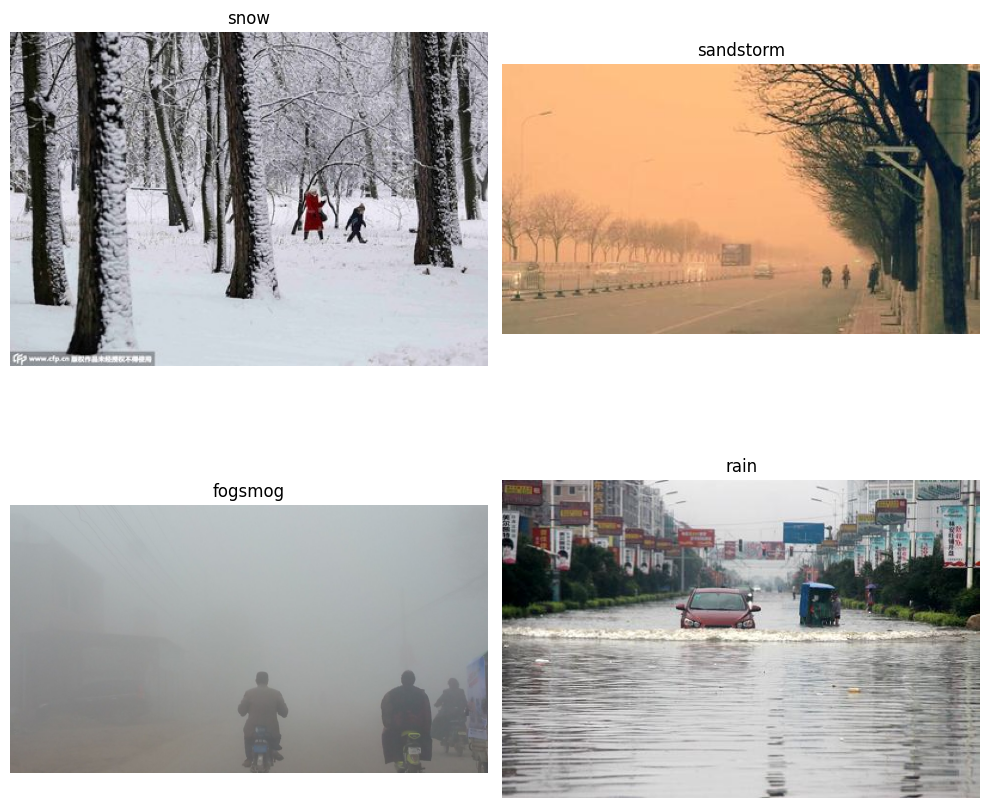

In [ ]:
classes = ['snow', 'sandstorm', 'fogsmog', 'rain']

plt.figure(figsize=(10,10))

for i, cls in enumerate(classes):
    class_folder = os.path.join(train_set, cls)

    images = [f for f in os.listdir(class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not images:
        print(f"No images were found {cls}")
        continue

    img_name = random.choice(images)
    img_path = os.path.join(class_folder, img_name)

    img = mpimg.imread(img_path)


    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def load_data(train_set):
    images = []
    labels = []
    size = (64,64)
    index = -1
    for weather_to_train in os.listdir(train_set):
        index += 1
        for image in os.listdir(os.path.join(train_set, weather_to_train )):
            img_path = os.path.join(train_set, weather_to_train , image)
            temp_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            temp_img = cv2.resize(temp_img, size)
            temp_img = np.expand_dims(temp_img, axis=-1)
            images.append(temp_img)
            labels.append(index)

    images = np.array(images)
    images = np.array(images).astype('float32') / 255.0
    labels = utils.to_categorical(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=100)

    print('Loaded', len(x_train), 'images for training. Train shape =', x_train.shape)
    print('Loaded', len(x_test), 'images for testing. Test shape =', x_test.shape)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_data(train_set)

Loaded 1058 images for training. Train shape = (1058, 64, 64, 1)
Loaded 118 images for testing. Test shape = (118, 64, 64, 1)


In [ ]:
x_train_n, x_val, y_train_n, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 100)
print("x_train:", x_train_n.shape)
print("y_train:", y_train_n.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (846, 64, 64, 1)
y_train: (846, 4)
x_val: (212, 64, 64, 1)
y_val: (212, 4)




# **MODELS**

# **CNN Model 1**

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4072 - loss: 1.3551 - precision: 0.4370 - recall: 0.2218
Epoch 1: val_loss improved from inf to 1.55293, saving model to best_model_1.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.4077 - loss: 1.3537 - precision: 0.4378 - recall: 0.2223 - val_accuracy: 0.2925 - val_loss: 1.5529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/100
 96/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5443 - loss: 0.9826 - precision: 0.6268 - recall: 0.4277
Epoch 2: val_loss did not improve from 1.55293
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.5431 - loss: 0.9876 - precision: 0.6234 - recall: 0.4267 - val_accuracy: 0.2925 - val_loss: 2.2334 - val_precision: 0.2925 - val_recall: 0.2925 - learning_rate: 5.0000e-04
Epoch 3/100
103/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5737 - loss: 0.9100 - precision: 0.6274 - recall: 0.4598
Epoch 3: val_loss did not improve from 1.55293
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5738 - loss: 0.9101 - precision: 0.6275 - recall: 0.4601 - val_accuracy: 0.2925 - val_loss: 2.3202 - val_precision: 0.2952 - val_recall: 

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5995 - loss: 0.8737 - precision: 0.6562 - recall: 0.4790 - val_accuracy: 0.3538 - val_loss: 1.4805 - val_precision: 0.4214 - val_recall: 0.3160 - learning_rate: 5.0000e-04
Epoch 5/100
 96/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5673 - loss: 0.8480 - precision: 0.5957 - recall: 0.4604
Epoch 5: val_loss improved from 1.48051 to 1.02471, saving model to best_model_1.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5689 - loss: 0.8474 - precision: 0.5987 - recall: 0.4638 - val_accuracy: 0.5047 - val_loss: 1.0247 - val_precision: 0.6190 - val_recall: 0.3679 - learning_rate: 5.0000e-04
Epoch 6/100
 97/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5968 - loss: 0.8347 - precision: 0.6403 - recall: 0.5159
Epoch 6: val_loss improved from 1.02471 to 0.81785, saving model to best_model_1.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5995 - loss: 0.8334 - precision: 0.6433 - recall: 0.5180 - val_accuracy: 0.5991 - val_loss: 0.8179 - val_precision: 0.6512 - val_recall: 0.5283 - learning_rate: 5.0000e-04
Epoch 7/100
 98/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6428 - loss: 0.7590 - precision: 0.6798 - recall: 0.5789
Epoch 7: val_loss did not improve from 0.81785
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6405 - loss: 0.7631 - precision: 0.6777 - recall: 0.5756 - val_accuracy: 0.5283 - val_loss: 1.0170 - val_precision: 0.5521 - val_recall: 0.5000 - learning_rate: 5.0000e-04
Epoch 8/100
100/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6439 - loss: 0.8007 - precision: 0.6916 - recall: 0.5685
Epoch 8: val_loss improved from 0.81785 to 0.77942, saving model to best_model_1.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6427 - loss: 0.8007 - precision: 0.6903 - recall: 0.5674 - val_accuracy: 0.6368 - val_loss: 0.7794 - val_precision: 0.6865 - val_recall: 0.5991 - learning_rate: 5.0000e-04
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5906 - loss: 0.8145 - precision: 0.6279 - recall: 0.4993
Epoch 9: val_loss improved from 0.77942 to 0.70510, saving model to best_model_1.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5910 - loss: 0.8140 - precision: 0.6283 - recall: 0.4997 - val_accuracy: 0.6840 - val_loss: 0.7051 - val_precision: 0.7293 - val_recall: 0.6226 - learning_rate: 5.0000e-04
Epoch 10/100
103/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6788 - loss: 0.6990 - precision: 0.7154 - recall: 0.6134
Epoch 10: val_loss improved from 0.70510 to 0.68314, saving model to best_model_1.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6787 - loss: 0.6991 - precision: 0.7153 - recall: 0.6132 - val_accuracy: 0.6840 - val_loss: 0.6831 - val_precision: 0.7120 - val_recall: 0.6415 - learning_rate: 5.0000e-04
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6951 - loss: 0.6791 - precision: 0.7326 - recall: 0.6214
Epoch 11: val_loss improved from 0.68314 to 0.63060, saving model to best_model_1.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6950 - loss: 0.6790 - precision: 0.7324 - recall: 0.6215 - val_accuracy: 0.6840 - val_loss: 0.6306 - val_precision: 0.7263 - val_recall: 0.6509 - learning_rate: 5.0000e-04
Epoch 12/100
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6654 - loss: 0.6736 - precision: 0.7085 - recall: 0.6074
Epoch 12: val_loss did not improve from 0.63060
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6661 - loss: 0.6737 - precision: 0.7094 - recall: 0.6080 - val_accuracy: 0.6792 - val_loss: 0.6596 - val_precision: 0.7421 - val_recall: 0.5566 - learning_rate: 5.0000e-04
Epoch 13/100
 99/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6963 - loss: 0.6733 - precision: 0.7402 - recall: 0.6393
Epoch 13: val_loss did not improve from 0.63060
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6967 - loss: 0.6718 - precision: 0.7405 - recall: 0.6387 - val_accuracy: 0.6321 - val_loss: 0.7654 - val_precision: 0.6771 - val_recall: 0.6132 -

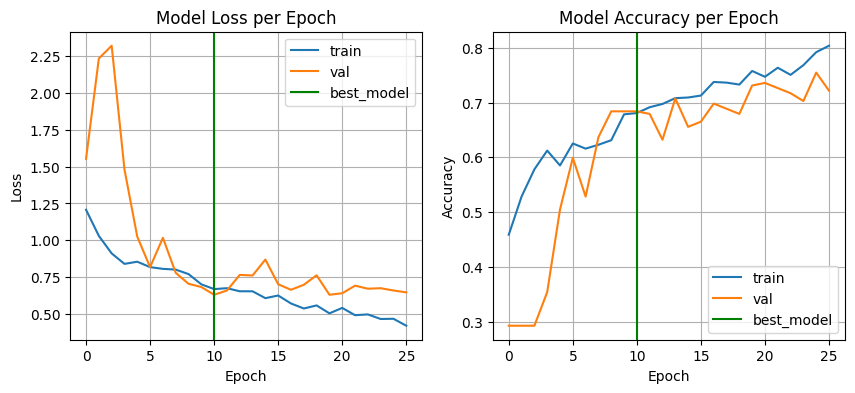

Validation Metrics:
Accuracy:  0.6840
Precision: 0.6934
Recall:    0.6840
F1 Score:  0.6844

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        62
           1       0.56      0.70      0.62        57
           2       0.84      0.71      0.77        45
           3       0.80      0.83      0.82        48

    accuracy                           0.68       212
   macro avg       0.71      0.69      0.70       212
weighted avg       0.69      0.68      0.68       212

[[33 26  0  3]
 [17 40  0  0]
 [ 3  3 32  7]
 [ 0  2  6 40]]


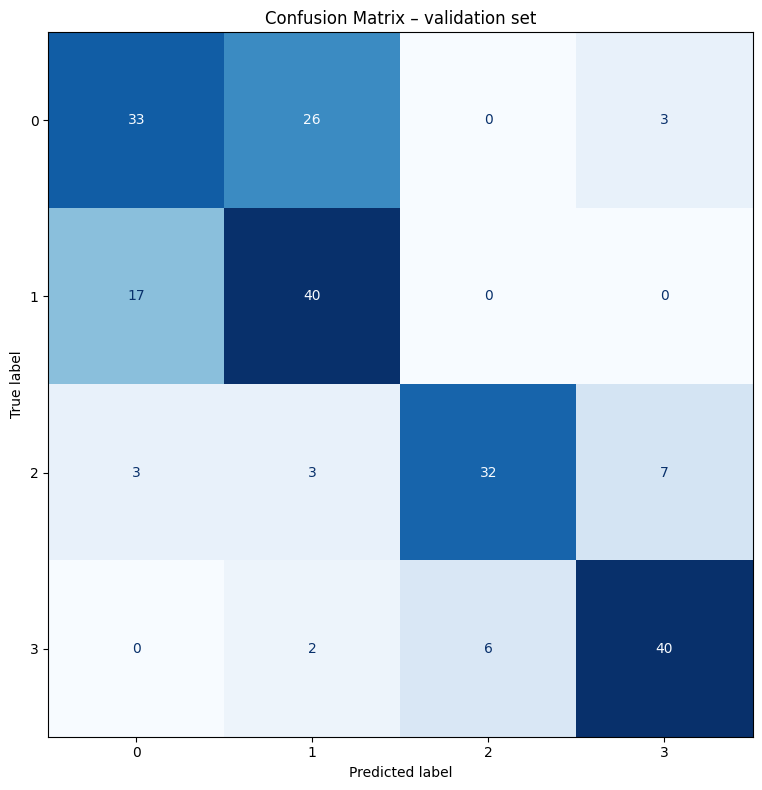

<Figure size 800x800 with 0 Axes>

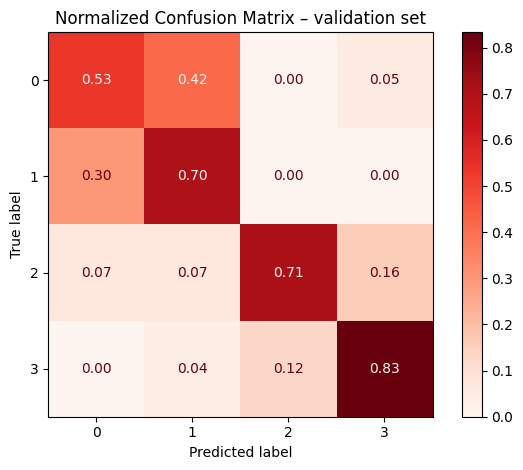

In [ ]:
classes = len(class_to_train)
batch = 8
epochs = 100
learning_rate = 5e-4
optimizer = Adam(learning_rate=learning_rate)

#model
model = Sequential()

#block 1
model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#block 2
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#block 3
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#block 4
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))


#Dense
model.add(Flatten())
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(classes, activation = 'softmax'))

# early-stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

#lr scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience= 5,
    min_lr=1e-6,
    verbose=2
)
save_model = ModelCheckpoint('best_model_1.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

#train
history_1 = model.fit(x_train_n, y_train_n, batch_size=batch, epochs=epochs, validation_data=(x_val, y_val), shuffle = True, verbose=1,
                    callbacks=[save_model, early_stopping, lr_scheduler])

#plot loss/accuracy
best_epoch = int(np.argmin(history_1.history['val_loss']))
best_val_acc = history_1.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")

#plot
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='upper right')
plt.grid()

plt.subplot(122)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='lower right')
plt.grid()
plt.show()

#predict
y_pred_probs = model.predict(x_val, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

#metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


#confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

#confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()


# **CNN Model 2**


Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4383 - loss: 1.4611 - precision: 0.4541 - recall: 0.3373
Epoch 1: val_loss improved from inf to 2.03803, saving model to best_model_2.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.4387 - loss: 1.4591 - precision: 0.4545 - recall: 0.3378 - val_accuracy: 0.2925 - val_loss: 2.0380 - val_precision: 0.2925 - val_recall: 0.2925 - learning_rate: 5.0000e-04
Epoch 2/100
100/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5007 - loss: 1.1031 - precision: 0.5295 - recall: 0.3901
Epoch 2: val_loss improved from 2.03803 to 1.98476, saving model to best_model_2.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5023 - loss: 1.0985 - precision: 0.5325 - recall: 0.3926 - val_accuracy: 0.2925 - val_loss: 1.9848 - val_precision: 0.2925 - val_recall: 0.2925 - learning_rate: 5.0000e-04
Epoch 3/100
101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5556 - loss: 0.9285 - precision: 0.5663 - recall: 0.4430
Epoch 3: val_loss improved from 1.98476 to 1.52069, saving model to best_model_2.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5551 - loss: 0.9298 - precision: 0.5672 - recall: 0.4441 - val_accuracy: 0.2925 - val_loss: 1.5207 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 4/100
101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5736 - loss: 0.8929 - precision: 0.6266 - recall: 0.4719
Epoch 4: val_loss did not improve from 1.52069
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5734 - loss: 0.8917 - precision: 0.6258 - recall: 0.4725 - val_accuracy: 0.2925 - val_loss: 2.5560 - val_precision: 0.3024 - val_recall: 0.2925 - learning_rate: 5.0000e-04
Epoch 5/100
100/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5563 - loss: 0.9198 - precision: 0.6344 - recall: 0.4931
Epoch 5: val_loss improved from 1.52069 to 1.09689, saving model to best_model_2.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5572 - loss: 0.9184 - precision: 0.6340 - recall: 0.4933 - val_accuracy: 0.4906 - val_loss: 1.0969 - val_precision: 0.5273 - val_recall: 0.4104 - learning_rate: 5.0000e-04
Epoch 6/100
101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6233 - loss: 0.8120 - precision: 0.6585 - recall: 0.5574
Epoch 6: val_loss did not improve from 1.09689
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6221 - loss: 0.8138 - precision: 0.6571 - recall: 0.5562 - val_accuracy: 0.4811 - val_loss: 1.1747 - val_precision: 0.5353 - val_recall: 0.4292 - learning_rate: 5.0000e-04
Epoch 7/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6170 - loss: 0.7761 - precision: 0.6410 - recall: 0.5278
Epoch 7: val_loss improved from 1.09689 to 0.86787, saving model to best_model_2.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6169 - loss: 0.7763 - precision: 0.6408 - recall: 0.5276 - val_accuracy: 0.5566 - val_loss: 0.8679 - val_precision: 0.6538 - val_recall: 0.4811 - learning_rate: 5.0000e-04
Epoch 8/100
100/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6013 - loss: 0.8125 - precision: 0.6341 - recall: 0.5352
Epoch 8: val_loss did not improve from 0.86787
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6014 - loss: 0.8122 - precision: 0.6340 - recall: 0.5343 - val_accuracy: 0.6038 - val_loss: 0.8887 - val_precision: 0.6436 - val_recall: 0.5708 - learning_rate: 5.0000e-04
Epoch 9/100
 99/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6380 - loss: 0.7521 - precision: 0.6765 - recall: 0.5726
Epoch 9: val_loss improved from 0.86787 to 0.70127, saving model to best_model_2.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6381 - loss: 0.7542 - precision: 0.6765 - recall: 0.5725 - val_accuracy: 0.6840 - val_loss: 0.7013 - val_precision: 0.7229 - val_recall: 0.5660 - learning_rate: 5.0000e-04
Epoch 10/100
102/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6472 - loss: 0.7523 - precision: 0.6717 - recall: 0.5797
Epoch 10: val_loss improved from 0.70127 to 0.69433, saving model to best_model_2.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6462 - loss: 0.7545 - precision: 0.6714 - recall: 0.5785 - val_accuracy: 0.6509 - val_loss: 0.6943 - val_precision: 0.6859 - val_recall: 0.6179 - learning_rate: 5.0000e-04
Epoch 11/100
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6188 - loss: 0.7921 - precision: 0.6530 - recall: 0.5557
Epoch 11: val_loss did not improve from 0.69433
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6191 - loss: 0.7911 - precision: 0.6536 - recall: 0.5559 - val_accuracy: 0.5896 - val_loss: 0.9975 - val_precision: 0.6066 - val_recall: 0.5236 - learning_rate: 5.0000e-04
Epoch 12/100
102/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6562 - loss: 0.7116 - precision: 0.7058 - recall: 0.6084
Epoch 12: val_loss did not improve from 0.69433
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6553 - loss: 0.7140 - precision: 0.7042 - recall: 0.6071 - val_accuracy: 0.6462 - val_loss: 0.7183 - val_precision: 0.6615 - val_recall: 0.6085 -

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6923 - loss: 0.6164 - precision: 0.7247 - recall: 0.6451 - val_accuracy: 0.6745 - val_loss: 0.6584 - val_precision: 0.7222 - val_recall: 0.6132 - learning_rate: 2.5000e-04
Epoch 18/100
 99/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7058 - loss: 0.6267 - precision: 0.7285 - recall: 0.6658
Epoch 18: val_loss did not improve from 0.65838
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7056 - loss: 0.6255 - precision: 0.7289 - recall: 0.6653 - val_accuracy: 0.6038 - val_loss: 1.0632 - val_precision: 0.6419 - val_recall: 0.4481 - learning_rate: 2.5000e-04
Epoch 19/100
100/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7702 - loss: 0.5347 - precision: 0.7839 - recall: 0.7255
Epoch 19: val_loss did not improve from 0.65838
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7682 - loss: 0.5372 - precision: 0.7822 - recall: 0.7240 - val_accuracy: 0.6321 - val_loss: 0.7714 - val_precision: 0.6632 - val_recall: 0.5943 -

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7442 - loss: 0.5050 - precision: 0.7715 - recall: 0.7178 - val_accuracy: 0.6934 - val_loss: 0.6426 - val_precision: 0.7024 - val_recall: 0.6792 - learning_rate: 1.2500e-04
Epoch 26/100
 97/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8062 - loss: 0.4031 - precision: 0.8133 - recall: 0.7829
Epoch 26: val_loss did not improve from 0.64264
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8052 - loss: 0.4046 - precision: 0.8130 - recall: 0.7819 - val_accuracy: 0.6745 - val_loss: 0.6571 - val_precision: 0.6970 - val_recall: 0.6509 - learning_rate: 1.2500e-04
Epoch 27/100
100/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7856 - loss: 0.4474 - precision: 0.8073 - recall: 0.7630
Epoch 27: val_loss did not improve from 0.64264
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7859 - loss: 0.4461 - precision: 0.8073 - recall: 0.7633 - val_accuracy: 0.6792 - val_loss: 0.6658 - val_precision: 0.6970 - val_recall: 0.6509 

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8133 - loss: 0.4048 - precision: 0.8217 - recall: 0.7902 - val_accuracy: 0.7217 - val_loss: 0.6262 - val_precision: 0.7277 - val_recall: 0.6934 - learning_rate: 6.2500e-05
Epoch 32/100
101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8040 - loss: 0.4047 - precision: 0.8217 - recall: 0.7837
Epoch 32: val_loss did not improve from 0.62621
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8049 - loss: 0.4026 - precision: 0.8223 - recall: 0.7848 - val_accuracy: 0.7123 - val_loss: 0.6732 - val_precision: 0.7304 - val_recall: 0.7028 - learning_rate: 6.2500e-05
Epoch 33/100
100/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8438 - loss: 0.3664 - precision: 0.8467 - recall: 0.8303
Epoch 33: val_loss did not improve from 0.62621
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8424 - loss: 0.3669 - precision: 0.8456 - recall: 0.8288 - val_accuracy: 0.7075 - val_loss: 0.6361 - val_precision: 0.7250 - val_recall: 0.6840 -

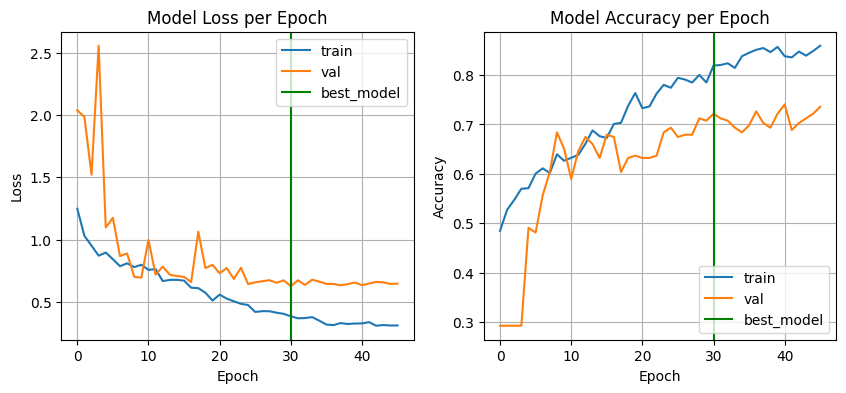

Validation Metrics:
Accuracy:  0.7217
Precision: 0.7253
Recall:    0.7217
F1 Score:  0.7213

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        62
           1       0.64      0.74      0.68        57
           2       0.77      0.80      0.78        45
           3       0.84      0.79      0.82        48

    accuracy                           0.72       212
   macro avg       0.73      0.73      0.73       212
weighted avg       0.73      0.72      0.72       212

[[37 22  3  0]
 [15 42  0  0]
 [ 1  1 36  7]
 [ 1  1  8 38]]


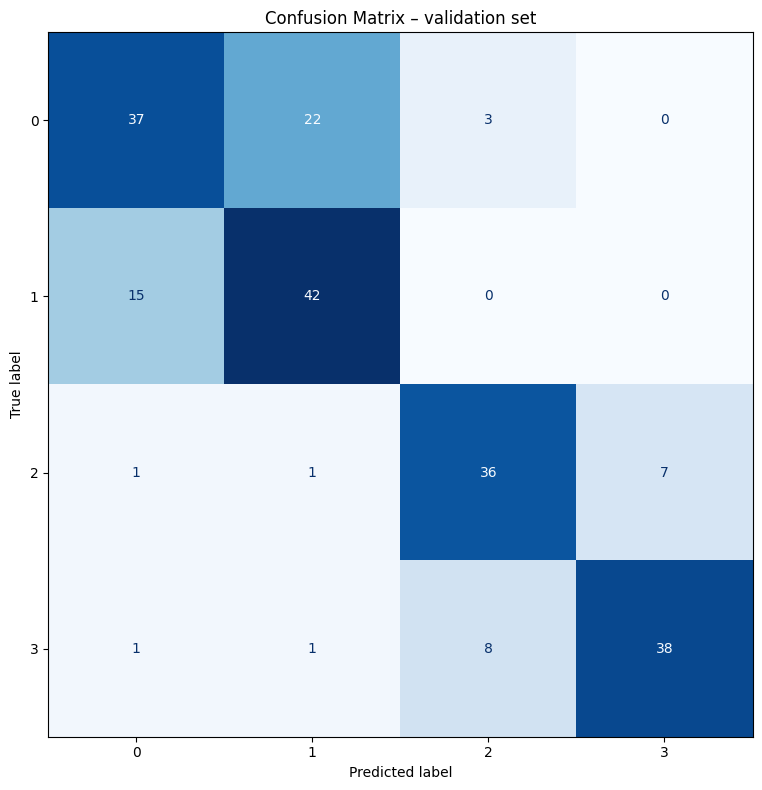

<Figure size 800x800 with 0 Axes>

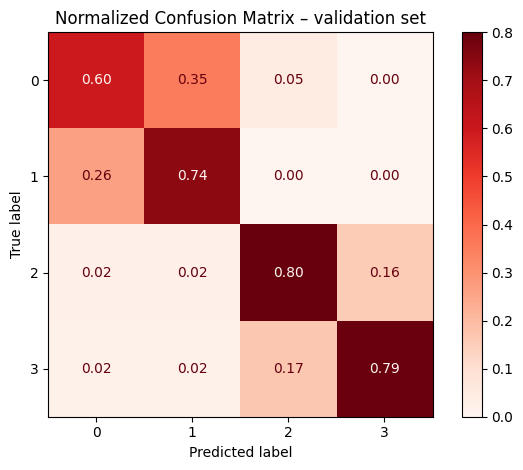

In [ ]:
classes = len(class_to_train)
batch = 8
epochs = 100
learning_rate = 5e-4
optimizer = AdamW(learning_rate=learning_rate, weight_decay=1e-5)

#model
model = Sequential()

#block 1
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.3))

#block 2
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#block 3
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#block 4
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#block 5
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Dense
model.add(Flatten())
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(classes, activation = 'softmax'))

#early-stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

#lr scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience= 5,
    min_lr=1e-6,
    verbose=2
)
save_model = ModelCheckpoint('best_model_2.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

#train
history_2 = model.fit(x_train_n, y_train_n, batch_size=batch, epochs=epochs, validation_data=(x_val, y_val), shuffle = True, verbose=1,
                    callbacks=[save_model, early_stopping, lr_scheduler])

#plot loss/accuracy
best_epoch = int(np.argmin(history_2.history['val_loss']))
best_val_acc = history_2.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")

#plot
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='upper right')
plt.grid()

plt.subplot(122)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='lower right')
plt.grid()
plt.show()

#predict
y_pred_probs = model.predict(x_val, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

#metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


#confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

#confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# **CNN Model 3**

Epoch 1/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2816 - loss: 2.0751 - precision: 0.2760 - recall: 0.1702
Epoch 1: val_loss improved from inf to 1.50200, saving model to best_model_3.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 132ms/step - accuracy: 0.2817 - loss: 2.0722 - precision: 0.2763 - recall: 0.1700 - val_accuracy: 0.2925 - val_loss: 1.5020 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3251 - loss: 1.4513 - precision: 0.4174 - recall: 0.1480
Epoch 2: val_loss did not improve from 1.50200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3255 - loss: 1.4505 - precision: 0.4178 - recall: 0.1484 - val_accuracy: 0.2689 - val_loss: 1.9415 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/80
 96/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4343 - loss: 1.2145 - precision: 0.5086 - recall: 0.2267
Epoch 3: val_loss did not improve from 1.50200
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4317 - loss: 1.2203 - precision: 0.5033 - recall: 0.2244 - val_accuracy: 0.2689 - val_loss: 2.0773 - val_precision: 0.2714 - val_recall: 0.2

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4874 - loss: 1.0235 - precision: 0.4923 - recall: 0.2885 - val_accuracy: 0.4481 - val_loss: 1.0390 - val_precision: 0.4627 - val_recall: 0.1462 - learning_rate: 0.0010
Epoch 7/80
 97/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4511 - loss: 1.0470 - precision: 0.4910 - recall: 0.2747
Epoch 7: val_loss improved from 1.03902 to 0.91658, saving model to best_model_3.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4548 - loss: 1.0419 - precision: 0.4953 - recall: 0.2791 - val_accuracy: 0.5330 - val_loss: 0.9166 - val_precision: 0.5842 - val_recall: 0.2783 - learning_rate: 0.0010
Epoch 8/80
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5068 - loss: 0.9928 - precision: 0.5421 - recall: 0.3404
Epoch 8: val_loss did not improve from 0.91658
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5068 - loss: 0.9917 - precision: 0.5421 - recall: 0.3404 - val_accuracy: 0.5283 - val_loss: 0.9620 - val_precision: 0.5660 - val_recall: 0.4245 - learning_rate: 0.0010
Epoch 9/80
101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4867 - loss: 1.0554 - precision: 0.5029 - recall: 0.3222
Epoch 9: val_loss did not improve from 0.91658
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4867 - loss: 1.0547 - precision: 0.5040 - recall: 0.3219 - val_accuracy: 0.4575 - val_loss: 1.0387 - val_precision: 0.5607 - val_recall: 0.2830 - learning_rate

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5091 - loss: 0.9770 - precision: 0.5550 - recall: 0.3385 - val_accuracy: 0.5613 - val_loss: 0.8162 - val_precision: 0.5839 - val_recall: 0.4434 - learning_rate: 0.0010
Epoch 11/80
102/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5186 - loss: 0.9401 - precision: 0.5419 - recall: 0.3664
Epoch 11: val_loss did not improve from 0.81622
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5184 - loss: 0.9407 - precision: 0.5425 - recall: 0.3663 - val_accuracy: 0.4670 - val_loss: 0.9840 - val_precision: 0.5385 - val_recall: 0.3962 - learning_rate: 0.0010
Epoch 12/80
 98/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5437 - loss: 0.8629 - precision: 0.5967 - recall: 0.3923
Epoch 12: val_loss did not improve from 0.81622
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5447 - loss: 0.8671 - precision: 0.5983 - recall: 0.3930 - val_accuracy: 0.5377 - val_loss: 0.8617 - val_precision: 0.6867 - val_recall: 0.2689 - learning_

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5716 - loss: 0.8296 - precision: 0.6350 - recall: 0.4941 - val_accuracy: 0.6132 - val_loss: 0.7609 - val_precision: 0.6912 - val_recall: 0.4434 - learning_rate: 5.0000e-04
Epoch 19/80
 97/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6023 - loss: 0.7967 - precision: 0.6383 - recall: 0.4613
Epoch 19: val_loss did not improve from 0.76089
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6014 - loss: 0.7986 - precision: 0.6378 - recall: 0.4617 - val_accuracy: 0.5047 - val_loss: 1.0451 - val_precision: 0.5621 - val_recall: 0.4481 - learning_rate: 5.0000e-04
Epoch 20/80
 98/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5670 - loss: 0.8021 - precision: 0.6319 - recall: 0.4496
Epoch 20: val_loss improved from 0.76089 to 0.75752, saving model to best_model_3.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5688 - loss: 0.8022 - precision: 0.6337 - recall: 0.4513 - val_accuracy: 0.6132 - val_loss: 0.7575 - val_precision: 0.7612 - val_recall: 0.4811 - learning_rate: 5.0000e-04
Epoch 21/80
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6655 - loss: 0.7681 - precision: 0.7007 - recall: 0.5459
Epoch 21: val_loss did not improve from 0.75752
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6643 - loss: 0.7696 - precision: 0.6995 - recall: 0.5449 - val_accuracy: 0.5660 - val_loss: 0.8075 - val_precision: 0.6479 - val_recall: 0.4340 - learning_rate: 5.0000e-04
Epoch 22/80
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6179 - loss: 0.7771 - precision: 0.6671 - recall: 0.4803
Epoch 22: val_loss did not improve from 0.75752
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6176 - loss: 0.7786 - precision: 0.6670 - recall: 0.4800 - val_accuracy: 0.6179 - val_loss: 0.7826 - val_precision: 0.8224 - val_recall: 0.4151 - 

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6618 - loss: 0.7332 - precision: 0.6951 - recall: 0.5310 - val_accuracy: 0.6274 - val_loss: 0.7561 - val_precision: 0.7214 - val_recall: 0.4764 - learning_rate: 5.0000e-04
Epoch 26/80
 98/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5995 - loss: 0.7672 - precision: 0.6471 - recall: 0.4865
Epoch 26: val_loss did not improve from 0.75610
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5999 - loss: 0.7683 - precision: 0.6476 - recall: 0.4877 - val_accuracy: 0.5566 - val_loss: 0.9274 - val_precision: 0.6803 - val_recall: 0.3915 - learning_rate: 5.0000e-04
Epoch 27/80
 99/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6041 - loss: 0.7262 - precision: 0.6684 - recall: 0.5125
Epoch 27: val_loss did not improve from 0.75610
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6053 - loss: 0.7289 - precision: 0.6688 - recall: 0.5121 - val_accuracy: 0.4198 - val_loss: 1.3989 - val_precision: 0.5447 - val_recall: 0.3160 - l

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6329 - loss: 0.7072 - precision: 0.6703 - recall: 0.5240 - val_accuracy: 0.6792 - val_loss: 0.7287 - val_precision: 0.7754 - val_recall: 0.5047 - learning_rate: 2.5000e-04
Epoch 32/80
 96/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6683 - loss: 0.7215 - precision: 0.7245 - recall: 0.5776
Epoch 32: val_loss did not improve from 0.72868
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6687 - loss: 0.7203 - precision: 0.7250 - recall: 0.5782 - val_accuracy: 0.6462 - val_loss: 0.7687 - val_precision: 0.7011 - val_recall: 0.5755 - learning_rate: 2.5000e-04
Epoch 33/80
102/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6730 - loss: 0.6932 - precision: 0.7247 - recall: 0.5946
Epoch 33: val_loss did not improve from 0.72868
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6727 - loss: 0.6934 - precision: 0.7245 - recall: 0.5944 - val_accuracy: 0.6321 - val_loss: 0.8494 - val_precision: 0.7436 - val_recall: 0.4104 - l

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6834 - loss: 0.6392 - precision: 0.7328 - recall: 0.5902 - val_accuracy: 0.6745 - val_loss: 0.6995 - val_precision: 0.7396 - val_recall: 0.5896 - learning_rate: 1.2500e-04
Epoch 40/80
 97/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7084 - loss: 0.6613 - precision: 0.7703 - recall: 0.6124
Epoch 40: val_loss did not improve from 0.69955
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7072 - loss: 0.6617 - precision: 0.7674 - recall: 0.6112 - val_accuracy: 0.6132 - val_loss: 0.8283 - val_precision: 0.6667 - val_recall: 0.5660 - learning_rate: 1.2500e-04
Epoch 41/80
 99/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7320 - loss: 0.6052 - precision: 0.7790 - recall: 0.6586
Epoch 41: val_loss did not improve from 0.69955
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7302 - loss: 0.6052 - precision: 0.7776 - recall: 0.6578 - val_accuracy: 0.6745 - val_loss: 0.7143 - val_precision: 0.7740 - val_recall: 0.5330 - l

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7364 - loss: 0.5519 - precision: 0.7599 - recall: 0.6725 - val_accuracy: 0.6698 - val_loss: 0.6790 - val_precision: 0.7135 - val_recall: 0.6226 - learning_rate: 1.2500e-04
Epoch 43/80
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7087 - loss: 0.5885 - precision: 0.7283 - recall: 0.6457
Epoch 43: val_loss did not improve from 0.67904
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7082 - loss: 0.5896 - precision: 0.7279 - recall: 0.6447 - val_accuracy: 0.6415 - val_loss: 0.7309 - val_precision: 0.7035 - val_recall: 0.5708 - learning_rate: 1.2500e-04
Epoch 44/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7071 - loss: 0.6007 - precision: 0.7190 - recall: 0.6311
Epoch 44: val_loss did not improve from 0.67904
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7072 - loss: 0.6006 - precision: 0.7192 - recall: 0.6312 - val_accuracy: 0.6604 - val_loss: 0.7626 - val_precision: 0.7305 - val_recall: 0.5755 - l

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7237 - loss: 0.5524 - precision: 0.7625 - recall: 0.6554 - val_accuracy: 0.7075 - val_loss: 0.6778 - val_precision: 0.7514 - val_recall: 0.6132 - learning_rate: 6.2500e-05
Epoch 50/80
102/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7237 - loss: 0.5915 - precision: 0.7738 - recall: 0.6580
Epoch 50: val_loss did not improve from 0.67782
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7235 - loss: 0.5916 - precision: 0.7727 - recall: 0.6577 - val_accuracy: 0.6840 - val_loss: 0.7047 - val_precision: 0.7189 - val_recall: 0.6274 - learning_rate: 6.2500e-05
Epoch 51/80
 98/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7414 - loss: 0.6537 - precision: 0.7837 - recall: 0.6537
Epoch 51: val_loss did not improve from 0.67782
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7407 - loss: 0.6492 - precision: 0.7823 - recall: 0.6541 - val_accuracy: 0.6887 - val_loss: 0.7011 - val_precision: 0.7297 - val_recall: 0.6368 - l

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7167 - loss: 0.5875 - precision: 0.7358 - recall: 0.6523 - val_accuracy: 0.6887 - val_loss: 0.6696 - val_precision: 0.7374 - val_recall: 0.6226 - learning_rate: 6.2500e-05
Epoch 55/80
 96/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7663 - loss: 0.5218 - precision: 0.8009 - recall: 0.7232
Epoch 55: val_loss did not improve from 0.66964
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7630 - loss: 0.5258 - precision: 0.7979 - recall: 0.7198 - val_accuracy: 0.6840 - val_loss: 0.6743 - val_precision: 0.7326 - val_recall: 0.6462 - learning_rate: 6.2500e-05
Epoch 56/80
 97/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7146 - loss: 0.6281 - precision: 0.7554 - recall: 0.6664
Epoch 56: val_loss did not improve from 0.66964
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7153 - loss: 0.6250 - precision: 0.7552 - recall: 0.6668 - val_accuracy: 0.6840 - val_loss: 0.7159 - val_precision: 0.7249 - val_recall: 0.6462 - l

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7358 - loss: 0.6000 - precision: 0.7750 - recall: 0.7021 - val_accuracy: 0.6981 - val_loss: 0.6660 - val_precision: 0.7584 - val_recall: 0.6368 - learning_rate: 6.2500e-05
Epoch 58/80
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7090 - loss: 0.5778 - precision: 0.7324 - recall: 0.6688
Epoch 58: val_loss did not improve from 0.66602
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7092 - loss: 0.5776 - precision: 0.7327 - recall: 0.6690 - val_accuracy: 0.6745 - val_loss: 0.6968 - val_precision: 0.7092 - val_recall: 0.6557 - learning_rate: 6.2500e-05
Epoch 59/80
102/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7161 - loss: 0.5684 - precision: 0.7353 - recall: 0.6579
Epoch 59: val_loss did not improve from 0.66602
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7167 - loss: 0.5689 - precision: 0.7358 - recall: 0.6585 - val_accuracy: 0.6840 - val_loss: 0.7000 - val_precision: 0.7391 - val_recall: 0.6415 - l

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7610 - loss: 0.5544 - precision: 0.7903 - recall: 0.7183 - val_accuracy: 0.6887 - val_loss: 0.6596 - val_precision: 0.7446 - val_recall: 0.6462 - learning_rate: 1.5625e-05
Epoch 69/80
 98/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7306 - loss: 0.5495 - precision: 0.7561 - recall: 0.6667
Epoch 69: val_loss did not improve from 0.65964
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7297 - loss: 0.5501 - precision: 0.7557 - recall: 0.6670 - val_accuracy: 0.6745 - val_loss: 0.6661 - val_precision: 0.7403 - val_recall: 0.6321 - learning_rate: 1.5625e-05
Epoch 70/80
 97/106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7646 - loss: 0.5003 - precision: 0.7861 - recall: 0.7026
Epoch 70: val_loss did not improve from 0.65964
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7639 - loss: 0.5038 - precision: 0.7851 - recall: 0.7025 - val_accuracy: 0.6557 - val_loss: 0.6727 - val_precision: 0.7374 - val_recall: 0.6226 - l

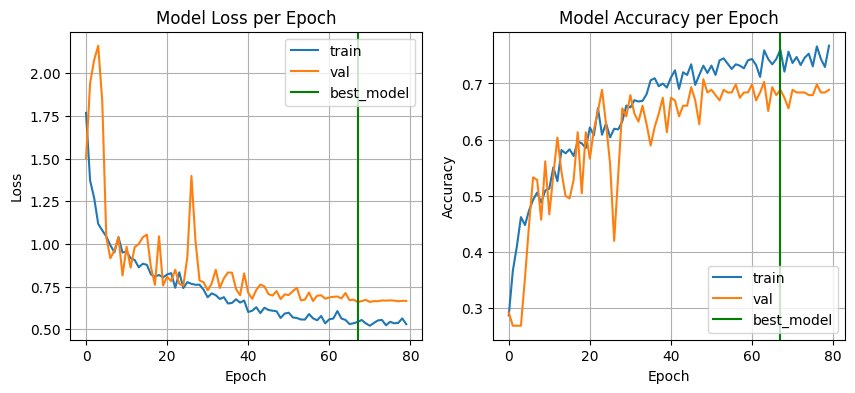

Validation Metrics:
Accuracy:  0.6887
Precision: 0.6977
Recall:    0.6887
F1 Score:  0.6904

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.53      0.56        62
           1       0.56      0.67      0.61        57
           2       0.79      0.82      0.80        45
           3       0.90      0.79      0.84        48

    accuracy                           0.69       212
   macro avg       0.71      0.70      0.71       212
weighted avg       0.70      0.69      0.69       212

[[33 26  2  1]
 [18 38  1  0]
 [ 2  3 37  3]
 [ 2  1  7 38]]


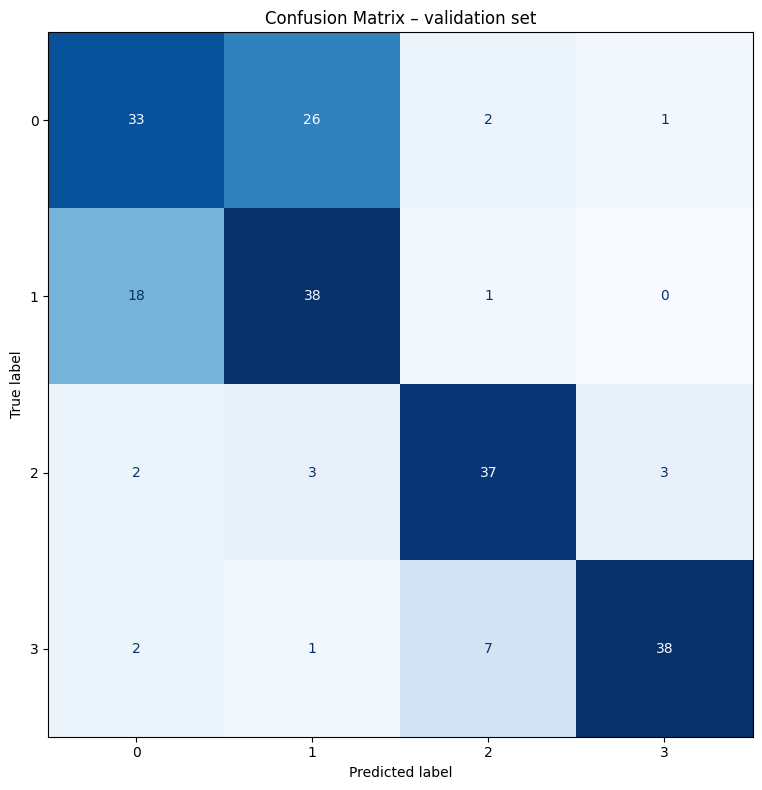

<Figure size 800x800 with 0 Axes>

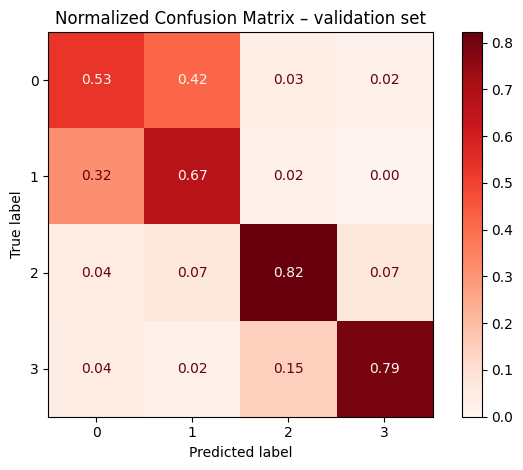

In [ ]:
classes = len(class_to_train)
batch = 8
epochs = 80
learning_rate = 1e-3
optimizer = AdamW(learning_rate=learning_rate)


#model
model = Sequential()

#block 1
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.4))

#block 2
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.4))
#block 3
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.4))
#block 4
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.4))

#block 5
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.4))

#block 6
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.4))

#dense
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation = 'softmax'))

#early-stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
#lr scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience= 5,
    min_lr=1e-6,
    verbose=2
)

save_model = ModelCheckpoint('best_model_3.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer='adamW', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

#train
history_3 = model.fit(x_train_n, y_train_n, batch_size=batch, epochs=epochs, validation_data=(x_val, y_val), shuffle = True, verbose=1,
                    callbacks=[save_model, early_stopping, lr_scheduler])

#plot loss/accuracy
best_epoch = int(np.argmin(history_3.history['val_loss']))
best_val_acc = history_3.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")

#plots
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='upper right')
plt.grid()

plt.subplot(122)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='lower right')
plt.grid()
plt.show()


#predict
y_pred_probs = model.predict(x_val, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

# metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


# confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# **CNN Model 4**


Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.2763 - loss: 1.3799 - precision: 0.6748 - recall: 0.0150
Epoch 1: val_loss improved from inf to 1.38534, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 459ms/step - accuracy: 0.2763 - loss: 1.3793 - precision: 0.6755 - recall: 0.0152 - val_accuracy: 0.3019 - val_loss: 1.3853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2731 - loss: 1.3588 - precision: 0.3359 - recall: 0.0084
Epoch 2: val_loss improved from 1.38534 to 1.38421, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2737 - loss: 1.3566 - precision: 0.3566 - recall: 0.0095 - val_accuracy: 0.4670 - val_loss: 1.3842 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3440 - loss: 1.2398 - precision: 0.6854 - recall: 0.1340
Epoch 3: val_loss improved from 1.38421 to 1.38240, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3462 - loss: 1.2378 - precision: 0.6863 - recall: 0.1358 - val_accuracy: 0.3632 - val_loss: 1.3824 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4414 - loss: 1.1765 - precision: 0.6140 - recall: 0.2043
Epoch 4: val_loss improved from 1.38240 to 1.37853, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4439 - loss: 1.1743 - precision: 0.6147 - recall: 0.2045 - val_accuracy: 0.3726 - val_loss: 1.3785 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5386 - loss: 1.0626 - precision: 0.6399 - recall: 0.2345
Epoch 5: val_loss improved from 1.37853 to 1.36614, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5401 - loss: 1.0609 - precision: 0.6423 - recall: 0.2364 - val_accuracy: 0.4009 - val_loss: 1.3661 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5295 - loss: 1.0130 - precision: 0.6086 - recall: 0.2851
Epoch 6: val_loss improved from 1.36614 to 1.34840, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5319 - loss: 1.0100 - precision: 0.6107 - recall: 0.2881 - val_accuracy: 0.3868 - val_loss: 1.3484 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6351 - loss: 0.8045 - precision: 0.7313 - recall: 0.5206
Epoch 7: val_loss improved from 1.34840 to 1.32048, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6334 - loss: 0.8076 - precision: 0.7276 - recall: 0.5180 - val_accuracy: 0.4623 - val_loss: 1.3205 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5708 - loss: 0.9069 - precision: 0.6055 - recall: 0.4154
Epoch 8: val_loss improved from 1.32048 to 1.29198, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5735 - loss: 0.9035 - precision: 0.6092 - recall: 0.4176 - val_accuracy: 0.4906 - val_loss: 1.2920 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/200
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6126 - loss: 0.7908 - precision: 0.6841 - recall: 0.5102
Epoch 9: val_loss improved from 1.29198 to 1.26027, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6136 - loss: 0.7944 - precision: 0.6813 - recall: 0.5114 - val_accuracy: 0.4387 - val_loss: 1.2603 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 10/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6517 - loss: 0.7979 - precision: 0.7000 - recall: 0.5370
Epoch 10: val_loss improved from 1.26027 to 1.24165, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6505 - loss: 0.7981 - precision: 0.6986 - recall: 0.5364 - val_accuracy: 0.5708 - val_loss: 1.2416 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 11/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6314 - loss: 0.8040 - precision: 0.6619 - recall: 0.5402
Epoch 11: val_loss improved from 1.24165 to 1.22424, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6313 - loss: 0.8043 - precision: 0.6619 - recall: 0.5399 - val_accuracy: 0.5377 - val_loss: 1.2242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 12/200
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6265 - loss: 0.7854 - precision: 0.6681 - recall: 0.5388
Epoch 12: val_loss improved from 1.22424 to 1.18299, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6277 - loss: 0.7852 - precision: 0.6697 - recall: 0.5398 - val_accuracy: 0.5189 - val_loss: 1.1830 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 13/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6235 - loss: 0.8398 - precision: 0.6564 - recall: 0.5272
Epoch 13: val_loss improved from 1.18299 to 1.15297, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6247 - loss: 0.8365 - precision: 0.6584 - recall: 0.5286 - val_accuracy: 0.5802 - val_loss: 1.1530 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 14/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6407 - loss: 0.7399 - precision: 0.6749 - recall: 0.5481
Epoch 14: val_loss improved from 1.15297 to 1.10554, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6406 - loss: 0.7409 - precision: 0.6747 - recall: 0.5491 - val_accuracy: 0.6132 - val_loss: 1.1055 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 15/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6400 - loss: 0.7585 - precision: 0.6673 - recall: 0.5655
Epoch 15: val_loss improved from 1.10554 to 1.10017, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6389 - loss: 0.7606 - precision: 0.6665 - recall: 0.5642 - val_accuracy: 0.6132 - val_loss: 1.1002 - val_precision: 1.0000 - val_recall: 0.0047 - learning_rate: 1.0000e-04
Epoch 16/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6520 - loss: 0.7548 - precision: 0.6970 - recall: 0.5657
Epoch 16: val_loss improved from 1.10017 to 1.05299, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6513 - loss: 0.7550 - precision: 0.6961 - recall: 0.5644 - val_accuracy: 0.6085 - val_loss: 1.0530 - val_precision: 1.0000 - val_recall: 0.0189 - learning_rate: 1.0000e-04
Epoch 17/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6751 - loss: 0.7056 - precision: 0.6905 - recall: 0.6154
Epoch 17: val_loss improved from 1.05299 to 1.02811, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6742 - loss: 0.7078 - precision: 0.6899 - recall: 0.6138 - val_accuracy: 0.6415 - val_loss: 1.0281 - val_precision: 1.0000 - val_recall: 0.0519 - learning_rate: 1.0000e-04
Epoch 18/200
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6330 - loss: 0.7485 - precision: 0.6746 - recall: 0.5467
Epoch 18: val_loss improved from 1.02811 to 0.98896, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6376 - loss: 0.7431 - precision: 0.6769 - recall: 0.5523 - val_accuracy: 0.6085 - val_loss: 0.9890 - val_precision: 0.9286 - val_recall: 0.1226 - learning_rate: 1.0000e-04
Epoch 19/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6648 - loss: 0.7609 - precision: 0.7059 - recall: 0.6053
Epoch 19: val_loss improved from 0.98896 to 0.97175, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6655 - loss: 0.7585 - precision: 0.7064 - recall: 0.6049 - val_accuracy: 0.6274 - val_loss: 0.9718 - val_precision: 0.8800 - val_recall: 0.1038 - learning_rate: 1.0000e-04
Epoch 20/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6773 - loss: 0.7068 - precision: 0.7086 - recall: 0.6306
Epoch 20: val_loss improved from 0.97175 to 0.94260, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6767 - loss: 0.7059 - precision: 0.7077 - recall: 0.6292 - val_accuracy: 0.5943 - val_loss: 0.9426 - val_precision: 0.7966 - val_recall: 0.2217 - learning_rate: 1.0000e-04
Epoch 21/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6466 - loss: 0.7912 - precision: 0.6764 - recall: 0.5663
Epoch 21: val_loss improved from 0.94260 to 0.91475, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6481 - loss: 0.7871 - precision: 0.6775 - recall: 0.5671 - val_accuracy: 0.5991 - val_loss: 0.9148 - val_precision: 0.8413 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 22/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6724 - loss: 0.7294 - precision: 0.7237 - recall: 0.5890
Epoch 22: val_loss did not improve from 0.91475
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6728 - loss: 0.7275 - precision: 0.7232 - recall: 0.5900 - val_accuracy: 0.6085 - val_loss: 0.9268 - val_precision: 0.7794 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 23/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6791 - loss: 0.6595 - precision: 0.7151 - recall: 0.6237
Epoch 23: val_loss improved from 0.91475 to 0.87488, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6796 - loss: 0.6606 - precision: 0.7152 - recall: 0.6242 - val_accuracy: 0.6415 - val_loss: 0.8749 - val_precision: 0.8696 - val_recall: 0.2830 - learning_rate: 1.0000e-04
Epoch 24/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6539 - loss: 0.7368 - precision: 0.6902 - recall: 0.5863
Epoch 24: val_loss improved from 0.87488 to 0.82222, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6562 - loss: 0.7336 - precision: 0.6924 - recall: 0.5890 - val_accuracy: 0.6368 - val_loss: 0.8222 - val_precision: 0.8073 - val_recall: 0.4151 - learning_rate: 1.0000e-04
Epoch 25/200
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6469 - loss: 0.7311 - precision: 0.6747 - recall: 0.5997
Epoch 25: val_loss improved from 0.82222 to 0.80202, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6484 - loss: 0.7288 - precision: 0.6761 - recall: 0.6012 - val_accuracy: 0.6509 - val_loss: 0.8020 - val_precision: 0.8333 - val_recall: 0.4245 - learning_rate: 1.0000e-04
Epoch 26/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6644 - loss: 0.7102 - precision: 0.7002 - recall: 0.6130
Epoch 26: val_loss did not improve from 0.80202
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6641 - loss: 0.7097 - precision: 0.7002 - recall: 0.6131 - val_accuracy: 0.6226 - val_loss: 0.8053 - val_precision: 0.8241 - val_recall: 0.4198 - learning_rate: 1.0000e-04
Epoch 27/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6915 - loss: 0.6284 - precision: 0.7214 - recall: 0.6215
Epoch 27: val_loss improved from 0.80202 to 0.78353, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6909 - loss: 0.6320 - precision: 0.7205 - recall: 0.6213 - val_accuracy: 0.6840 - val_loss: 0.7835 - val_precision: 0.7923 - val_recall: 0.4858 - learning_rate: 1.0000e-04
Epoch 28/200
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7266 - loss: 0.6738 - precision: 0.7478 - recall: 0.6537
Epoch 28: val_loss improved from 0.78353 to 0.77564, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7230 - loss: 0.6742 - precision: 0.7455 - recall: 0.6510 - val_accuracy: 0.6604 - val_loss: 0.7756 - val_precision: 0.8125 - val_recall: 0.4906 - learning_rate: 1.0000e-04
Epoch 29/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7187 - loss: 0.6268 - precision: 0.7569 - recall: 0.6717
Epoch 29: val_loss improved from 0.77564 to 0.74961, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7179 - loss: 0.6287 - precision: 0.7553 - recall: 0.6715 - val_accuracy: 0.6462 - val_loss: 0.7496 - val_precision: 0.7801 - val_recall: 0.5189 - learning_rate: 1.0000e-04
Epoch 30/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7029 - loss: 0.6571 - precision: 0.7505 - recall: 0.6560
Epoch 30: val_loss improved from 0.74961 to 0.73504, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7028 - loss: 0.6566 - precision: 0.7501 - recall: 0.6561 - val_accuracy: 0.6415 - val_loss: 0.7350 - val_precision: 0.7099 - val_recall: 0.5425 - learning_rate: 1.0000e-04
Epoch 31/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6744 - loss: 0.6904 - precision: 0.6927 - recall: 0.6193
Epoch 31: val_loss did not improve from 0.73504
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6752 - loss: 0.6886 - precision: 0.6940 - recall: 0.6198 - val_accuracy: 0.6274 - val_loss: 0.7387 - val_precision: 0.7208 - val_recall: 0.5236 - learning_rate: 1.0000e-04
Epoch 32/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7141 - loss: 0.6641 - precision: 0.7353 - recall: 0.6608
Epoch 32: val_loss improved from 0.73504 to 0.73409, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7135 - loss: 0.6653 - precision: 0.7351 - recall: 0.6601 - val_accuracy: 0.6462 - val_loss: 0.7341 - val_precision: 0.7500 - val_recall: 0.5519 - learning_rate: 1.0000e-04
Epoch 33/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7138 - loss: 0.6199 - precision: 0.7470 - recall: 0.6666
Epoch 33: val_loss did not improve from 0.73409
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7129 - loss: 0.6212 - precision: 0.7457 - recall: 0.6652 - val_accuracy: 0.6698 - val_loss: 0.7350 - val_precision: 0.7763 - val_recall: 0.5566 - learning_rate: 1.0000e-04
Epoch 34/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7210 - loss: 0.6157 - precision: 0.7421 - recall: 0.6799
Epoch 34: val_loss improved from 0.73409 to 0.72832, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7200 - loss: 0.6168 - precision: 0.7410 - recall: 0.6781 - val_accuracy: 0.6698 - val_loss: 0.7283 - val_precision: 0.7867 - val_recall: 0.5566 - learning_rate: 1.0000e-04
Epoch 35/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6933 - loss: 0.6881 - precision: 0.7199 - recall: 0.6354
Epoch 35: val_loss improved from 0.72832 to 0.72663, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6956 - loss: 0.6833 - precision: 0.7221 - recall: 0.6379 - val_accuracy: 0.6698 - val_loss: 0.7266 - val_precision: 0.7294 - val_recall: 0.5849 - learning_rate: 1.0000e-04
Epoch 36/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7086 - loss: 0.6326 - precision: 0.7286 - recall: 0.6695
Epoch 36: val_loss did not improve from 0.72663
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7088 - loss: 0.6321 - precision: 0.7291 - recall: 0.6697 - val_accuracy: 0.6179 - val_loss: 0.7332 - val_precision: 0.6384 - val_recall: 0.5330 - learning_rate: 1.0000e-04
Epoch 37/200
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7205 - loss: 0.6354 - precision: 0.7332 - recall: 0.6677
Epoch 37: val_loss improved from 0.72663 to 0.71420, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7190 - loss: 0.6356 - precision: 0.7323 - recall: 0.6633 - val_accuracy: 0.6698 - val_loss: 0.7142 - val_precision: 0.7455 - val_recall: 0.5802 - learning_rate: 1.0000e-04
Epoch 38/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7093 - loss: 0.6410 - precision: 0.7483 - recall: 0.6751
Epoch 38: val_loss did not improve from 0.71420
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7091 - loss: 0.6407 - precision: 0.7475 - recall: 0.6740 - val_accuracy: 0.6226 - val_loss: 0.7404 - val_precision: 0.6936 - val_recall: 0.5660 - learning_rate: 1.0000e-04
Epoch 39/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7368 - loss: 0.5756 - precision: 0.7565 - recall: 0.6986
Epoch 39: val_loss did not improve from 0.71420
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7357 - loss: 0.5780 - precision: 0.7556 - recall: 0.6970 - val_accuracy: 0.6415 - val_loss: 0.7247 - val_precision: 0.7126 - val_recall: 0.5613 - lear

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7548 - loss: 0.5535 - precision: 0.7739 - recall: 0.7113 - val_accuracy: 0.6698 - val_loss: 0.6979 - val_precision: 0.7330 - val_recall: 0.6085 - learning_rate: 5.0000e-05
Epoch 45/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7192 - loss: 0.6393 - precision: 0.7312 - recall: 0.6761
Epoch 45: val_loss did not improve from 0.69790
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7209 - loss: 0.6354 - precision: 0.7333 - recall: 0.6772 - val_accuracy: 0.6745 - val_loss: 0.7157 - val_precision: 0.7241 - val_recall: 0.5943 - learning_rate: 5.0000e-05
Epoch 46/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7468 - loss: 0.5672 - precision: 0.7624 - recall: 0.7153
Epoch 46: val_loss did not improve from 0.69790
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7446 - loss: 0.5705 - precision: 0.7606 - recall: 0.7130 - val_accuracy: 0.6462 - val_loss: 0.6996 - val_precision: 0.7168 - val_recall: 0.5849 - lear

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7026 - loss: 0.5981 - precision: 0.7207 - recall: 0.6580 - val_accuracy: 0.6368 - val_loss: 0.6973 - val_precision: 0.7283 - val_recall: 0.5943 - learning_rate: 2.5000e-05
Epoch 51/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7032 - loss: 0.6139 - precision: 0.7335 - recall: 0.6582
Epoch 51: val_loss did not improve from 0.69730
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7042 - loss: 0.6119 - precision: 0.7341 - recall: 0.6595 - val_accuracy: 0.6321 - val_loss: 0.7008 - val_precision: 0.7159 - val_recall: 0.5943 - learning_rate: 2.5000e-05
Epoch 52/200
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7414 - loss: 0.5943 - precision: 0.7545 - recall: 0.6995
Epoch 52: val_loss improved from 0.69730 to 0.69473, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7424 - loss: 0.5941 - precision: 0.7558 - recall: 0.7002 - val_accuracy: 0.6462 - val_loss: 0.6947 - val_precision: 0.7412 - val_recall: 0.5943 - learning_rate: 2.5000e-05
Epoch 53/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7568 - loss: 0.5699 - precision: 0.7820 - recall: 0.7220
Epoch 53: val_loss did not improve from 0.69473
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7564 - loss: 0.5698 - precision: 0.7811 - recall: 0.7216 - val_accuracy: 0.6651 - val_loss: 0.7088 - val_precision: 0.7241 - val_recall: 0.5943 - learning_rate: 2.5000e-05
Epoch 54/200
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7446 - loss: 0.5926 - precision: 0.7569 - recall: 0.6979
Epoch 54: val_loss did not improve from 0.69473
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7455 - loss: 0.5900 - precision: 0.7589 - recall: 0.6994 - val_accuracy: 0.6321 - val_loss: 0.6966 - val_precision: 0.7267 - val_recall: 0.5896 - lear

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7663 - loss: 0.5623 - precision: 0.7934 - recall: 0.7120 - val_accuracy: 0.6604 - val_loss: 0.6937 - val_precision: 0.7310 - val_recall: 0.5896 - learning_rate: 2.5000e-05
Epoch 56/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7311 - loss: 0.5685 - precision: 0.7471 - recall: 0.6943
Epoch 56: val_loss did not improve from 0.69369
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7318 - loss: 0.5691 - precision: 0.7478 - recall: 0.6947 - val_accuracy: 0.6840 - val_loss: 0.6998 - val_precision: 0.7414 - val_recall: 0.6085 - learning_rate: 2.5000e-05
Epoch 57/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7341 - loss: 0.6009 - precision: 0.7441 - recall: 0.6943
Epoch 57: val_loss improved from 0.69369 to 0.69321, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7340 - loss: 0.5996 - precision: 0.7448 - recall: 0.6940 - val_accuracy: 0.6462 - val_loss: 0.6932 - val_precision: 0.7102 - val_recall: 0.5896 - learning_rate: 2.5000e-05
Epoch 58/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7409 - loss: 0.5640 - precision: 0.7674 - recall: 0.7007
Epoch 58: val_loss improved from 0.69321 to 0.68696, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7399 - loss: 0.5645 - precision: 0.7662 - recall: 0.6996 - val_accuracy: 0.6604 - val_loss: 0.6870 - val_precision: 0.7341 - val_recall: 0.5991 - learning_rate: 2.5000e-05
Epoch 59/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7260 - loss: 0.5492 - precision: 0.7329 - recall: 0.6792
Epoch 59: val_loss improved from 0.68696 to 0.68304, saving model to best_model_4.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7265 - loss: 0.5500 - precision: 0.7338 - recall: 0.6800 - val_accuracy: 0.6604 - val_loss: 0.6830 - val_precision: 0.7283 - val_recall: 0.5943 - learning_rate: 2.5000e-05
Epoch 60/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7168 - loss: 0.5978 - precision: 0.7398 - recall: 0.6890
Epoch 60: val_loss did not improve from 0.68304
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7169 - loss: 0.5977 - precision: 0.7398 - recall: 0.6894 - val_accuracy: 0.6557 - val_loss: 0.6952 - val_precision: 0.7396 - val_recall: 0.5896 - learning_rate: 2.5000e-05
Epoch 61/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7437 - loss: 0.5388 - precision: 0.7711 - recall: 0.7101
Epoch 61: val_loss did not improve from 0.68304
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7430 - loss: 0.5412 - precision: 0.7697 - recall: 0.7089 - val_accuracy: 0.6557 - val_loss: 0.6897 - val_precision: 0.7427 - val_recall: 0.5991 - lear

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7346 - loss: 0.5720 - precision: 0.7556 - recall: 0.6980 - val_accuracy: 0.6462 - val_loss: 0.6829 - val_precision: 0.7356 - val_recall: 0.6038 - learning_rate: 6.2500e-06
Epoch 72/200
22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7421 - loss: 0.5733 - precision: 0.7538 - recall: 0.7001
Epoch 72: val_loss did not improve from 0.68286
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7403 - loss: 0.5737 - precision: 0.7532 - recall: 0.7004 - val_accuracy: 0.6557 - val_loss: 0.6865 - val_precision: 0.7330 - val_recall: 0.6085 - learning_rate: 6.2500e-06
Epoch 73/200
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7361 - loss: 0.5747 - precision: 0.7492 - recall: 0.6948
Epoch 73: val_loss did not improve from 0.68286
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7358 - loss: 0.5740 - precision: 0.7489 - recall: 0.6948 - val_accuracy: 0.6509 - val_loss: 0.6868 - val_precision: 0.7414 - val_recall: 0.6085 - lear

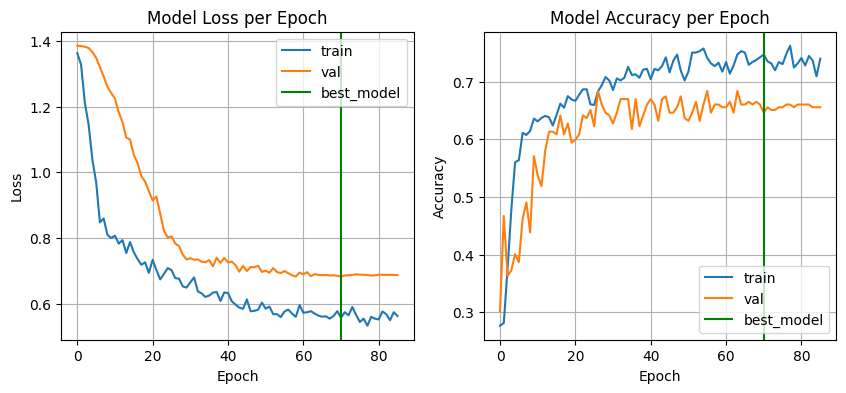

Validation Metrics:
Accuracy:  0.6462
Precision: 0.6485
Recall:    0.6462
F1 Score:  0.6461

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.66      0.62        62
           1       0.58      0.53      0.55        57
           2       0.72      0.73      0.73        45
           3       0.75      0.69      0.72        48

    accuracy                           0.65       212
   macro avg       0.66      0.65      0.65       212
weighted avg       0.65      0.65      0.65       212

[[41 18  1  2]
 [25 30  1  1]
 [ 3  1 33  8]
 [ 1  3 11 33]]


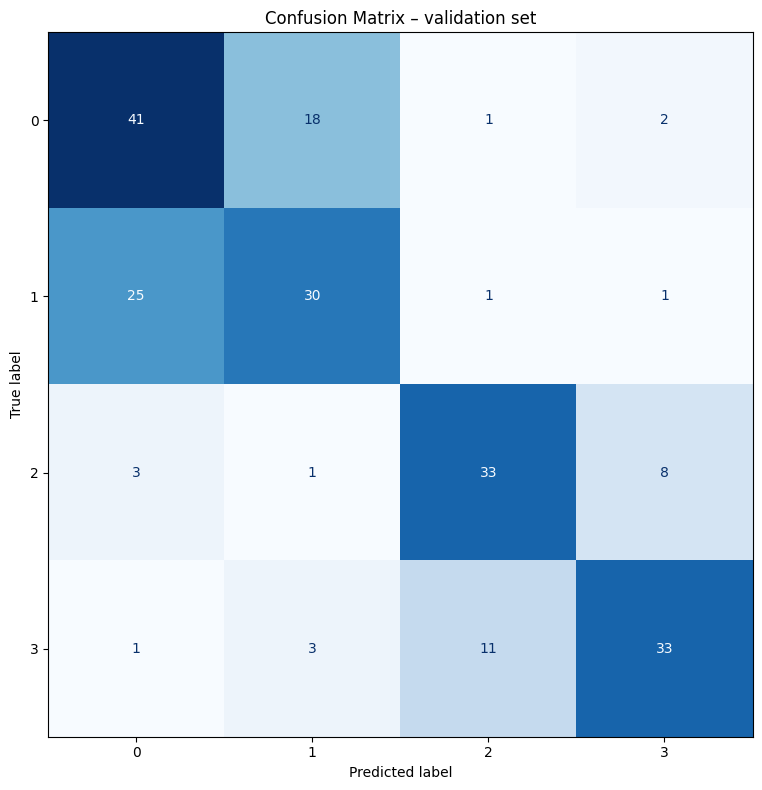

<Figure size 800x800 with 0 Axes>

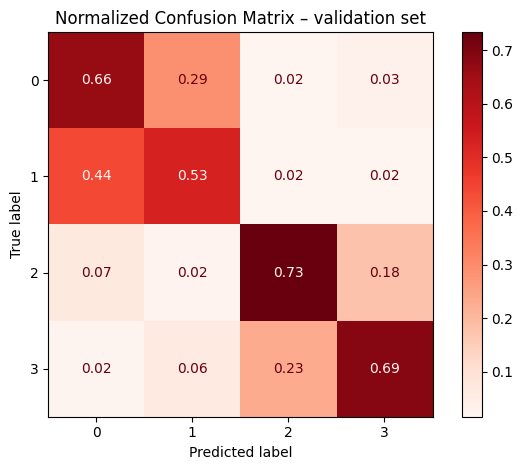

In [ ]:
classes = len(class_to_train)
batch = 32
epochs = 200
learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)

#model
model = Sequential()

#block 1
model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.3))

#block 2
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.3))

#block 3
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.3))

#block 4
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.3))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))

#dense
model.add(Flatten())
model.add(Dense(units = 64 , activation = 'relu' ))
model.add(Dropout(0.2))
model.add(Dense(units = 32 , activation = 'relu' ))
model.add(Dropout(0.2))
model.add(Dense(classes, activation = 'softmax'))


#early-stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

#lr schedurer
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience= 5,
    min_lr=1e-6,
    verbose=2
)
save_model = ModelCheckpoint('best_model_4.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

#train
history_4 = model.fit(x_train_n, y_train_n, batch_size=batch, epochs=epochs, validation_data=(x_val, y_val), shuffle = True, verbose=1,
                    callbacks=[save_model, early_stopping, lr_scheduler])

# check if early stopping occurred
if early_stopping.stopped_epoch > 0:
    print(f"\nTraining stopped early at epoch {early_stopping.stopped_epoch + 1}")
    print(f"Best validation loss: {min(history_4.history['val_loss']):.4f}")

# test evaluation
test_loss, test_acc, test_precision, test_recall = model.evaluate(x_test, y_test, verbose=0)

#plot loss/accuracy
best_epoch = int(np.argmin(history_4.history['val_loss']))
best_val_acc = history_4.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")

#plots
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='upper right')
plt.grid()

plt.subplot(122)
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='lower right')
plt.grid()
plt.show()


#predict
y_pred_probs = model.predict(x_val, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

# metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


#confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

#confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# **CNN Model 5**
Residual custom network

In [ ]:
def conv_block(x_in, kernel_size=(3,3), filters=64, strides=1, padding='same', dropout=0):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu')(x_in)
  x = BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  x = Dropout(rate=dropout)(x)
  return x

def res_block(x_in, kernel_size=(3,3), filters=64, strides=1, padding='same', dropout=0):
    x = conv_block(x_in, kernel_size, filters, strides, padding, dropout)
    if x_in.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x_in)
    else:
        shortcut = x_in
    x_out = Add()([x, shortcut])
    return x_out

def dense_block(x_in, units=128, dropout=0.5):
  x = Dense(units=units)(x_in)
  x = BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  x = Dropout(rate=dropout)(x)

  return x

Epoch 1/70


67/67 - 36s - 541ms/step - accuracy: 0.4679 - loss: 1.2156 - val_accuracy: 0.2925 - val_loss: 1.5964 - learning_rate: 1.0000e-03
Epoch 2/70
67/67 - 14s - 212ms/step - accuracy: 0.5217 - loss: 1.0372 - val_accuracy: 0.2925 - val_loss: 2.1171 - learning_rate: 1.0000e-03
Epoch 3/70
67/67 - 3s - 49ms/step - accuracy: 0.5775 - loss: 0.9279 - val_accuracy: 0.2925 - val_loss: 2.3453 - learning_rate: 1.0000e-03
Epoch 4/70

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
67/67 - 5s - 78ms/step - accuracy: 0.5671 - loss: 0.9334 - val_accuracy: 0.2689 - val_loss: 2.5382 - learning_rate: 1.0000e-03
Epoch 5/70
67/67 - 5s - 75ms/step - accuracy: 0.5794 - loss: 0.8767 - val_accuracy: 0.3585 - val_loss: 2.3904 - learning_rate: 5.0000e-04
Epoch 6/70
67/67 - 5s - 75ms/step - accuracy: 0.5756 - loss: 0.8921 - val_accuracy: 0.2925 - val_loss: 1.8609 - learning_rate: 5.0000e-04
Epoch 7/70


67/67 - 3s - 51ms/step - accuracy: 0.5000 - loss: 1.0860 - val_accuracy: 0.3491 - val_loss: 1.2563 - learning_rate: 5.0000e-04
Epoch 8/70


67/67 - 5s - 76ms/step - accuracy: 0.5567 - loss: 0.9249 - val_accuracy: 0.4575 - val_loss: 1.1197 - learning_rate: 5.0000e-04
Epoch 9/70


67/67 - 5s - 72ms/step - accuracy: 0.5974 - loss: 0.8510 - val_accuracy: 0.5708 - val_loss: 0.9701 - learning_rate: 5.0000e-04
Epoch 10/70


67/67 - 5s - 76ms/step - accuracy: 0.5983 - loss: 0.8614 - val_accuracy: 0.5283 - val_loss: 0.9066 - learning_rate: 5.0000e-04
Epoch 11/70
67/67 - 5s - 74ms/step - accuracy: 0.6191 - loss: 0.8385 - val_accuracy: 0.2972 - val_loss: 4.9773 - learning_rate: 5.0000e-04
Epoch 12/70
67/67 - 5s - 78ms/step - accuracy: 0.6125 - loss: 0.8459 - val_accuracy: 0.2783 - val_loss: 8.8606 - learning_rate: 5.0000e-04
Epoch 13/70

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
67/67 - 3s - 44ms/step - accuracy: 0.5463 - loss: 0.9563 - val_accuracy: 0.3396 - val_loss: 3.1094 - learning_rate: 5.0000e-04
Epoch 14/70
67/67 - 5s - 77ms/step - accuracy: 0.5898 - loss: 0.8580 - val_accuracy: 0.3443 - val_loss: 1.6544 - learning_rate: 2.5000e-04
Epoch 15/70
67/67 - 5s - 78ms/step - accuracy: 0.5860 - loss: 0.8226 - val_accuracy: 0.5708 - val_loss: 0.9071 - learning_rate: 2.5000e-04
Epoch 16/70


67/67 - 3s - 47ms/step - accuracy: 0.6096 - loss: 0.8286 - val_accuracy: 0.6368 - val_loss: 0.7695 - learning_rate: 2.5000e-04
Epoch 17/70


67/67 - 3s - 46ms/step - accuracy: 0.6295 - loss: 0.8080 - val_accuracy: 0.6698 - val_loss: 0.7533 - learning_rate: 2.5000e-04
Epoch 18/70


67/67 - 5s - 79ms/step - accuracy: 0.6248 - loss: 0.7758 - val_accuracy: 0.6604 - val_loss: 0.6661 - learning_rate: 2.5000e-04
Epoch 19/70
67/67 - 5s - 76ms/step - accuracy: 0.6408 - loss: 0.7859 - val_accuracy: 0.6462 - val_loss: 0.7367 - learning_rate: 2.5000e-04
Epoch 20/70
67/67 - 5s - 75ms/step - accuracy: 0.6493 - loss: 0.7672 - val_accuracy: 0.5236 - val_loss: 1.0591 - learning_rate: 2.5000e-04
Epoch 21/70

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
67/67 - 3s - 47ms/step - accuracy: 0.6720 - loss: 0.7475 - val_accuracy: 0.6745 - val_loss: 0.7322 - learning_rate: 2.5000e-04
Epoch 22/70
67/67 - 3s - 48ms/step - accuracy: 0.6474 - loss: 0.7779 - val_accuracy: 0.5566 - val_loss: 0.9152 - learning_rate: 1.2500e-04
Epoch 23/70


67/67 - 3s - 50ms/step - accuracy: 0.6673 - loss: 0.7259 - val_accuracy: 0.7311 - val_loss: 0.6203 - learning_rate: 1.2500e-04
Epoch 24/70


67/67 - 3s - 51ms/step - accuracy: 0.6786 - loss: 0.7500 - val_accuracy: 0.7453 - val_loss: 0.5977 - learning_rate: 1.2500e-04
Epoch 25/70
67/67 - 5s - 72ms/step - accuracy: 0.6730 - loss: 0.7087 - val_accuracy: 0.7217 - val_loss: 0.6328 - learning_rate: 1.2500e-04
Epoch 26/70
67/67 - 5s - 75ms/step - accuracy: 0.6919 - loss: 0.7183 - val_accuracy: 0.5755 - val_loss: 0.8559 - learning_rate: 1.2500e-04
Epoch 27/70

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
67/67 - 3s - 45ms/step - accuracy: 0.6607 - loss: 0.7089 - val_accuracy: 0.6651 - val_loss: 0.7457 - learning_rate: 1.2500e-04
Epoch 28/70


67/67 - 5s - 81ms/step - accuracy: 0.6975 - loss: 0.6704 - val_accuracy: 0.7547 - val_loss: 0.5943 - learning_rate: 6.2500e-05
Epoch 29/70


67/67 - 3s - 49ms/step - accuracy: 0.6928 - loss: 0.7090 - val_accuracy: 0.8160 - val_loss: 0.5281 - learning_rate: 6.2500e-05
Epoch 30/70
67/67 - 5s - 72ms/step - accuracy: 0.6919 - loss: 0.7200 - val_accuracy: 0.7170 - val_loss: 0.6757 - learning_rate: 6.2500e-05
Epoch 31/70
67/67 - 5s - 78ms/step - accuracy: 0.6881 - loss: 0.6794 - val_accuracy: 0.7311 - val_loss: 0.6074 - learning_rate: 6.2500e-05
Epoch 32/70

Epoch 32: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
67/67 - 3s - 46ms/step - accuracy: 0.6758 - loss: 0.7393 - val_accuracy: 0.7453 - val_loss: 0.6026 - learning_rate: 6.2500e-05
Epoch 33/70
67/67 - 5s - 77ms/step - accuracy: 0.7089 - loss: 0.6621 - val_accuracy: 0.7925 - val_loss: 0.5301 - learning_rate: 3.1250e-05
Epoch 34/70


67/67 - 5s - 76ms/step - accuracy: 0.7098 - loss: 0.6671 - val_accuracy: 0.7972 - val_loss: 0.5037 - learning_rate: 3.1250e-05
Epoch 35/70


67/67 - 5s - 78ms/step - accuracy: 0.6975 - loss: 0.6706 - val_accuracy: 0.8208 - val_loss: 0.4919 - learning_rate: 3.1250e-05
Epoch 36/70
67/67 - 5s - 75ms/step - accuracy: 0.7212 - loss: 0.6535 - val_accuracy: 0.7783 - val_loss: 0.5462 - learning_rate: 3.1250e-05
Epoch 37/70
67/67 - 5s - 76ms/step - accuracy: 0.7070 - loss: 0.6872 - val_accuracy: 0.8019 - val_loss: 0.4949 - learning_rate: 3.1250e-05
Epoch 38/70


67/67 - 3s - 49ms/step - accuracy: 0.7202 - loss: 0.6554 - val_accuracy: 0.8066 - val_loss: 0.4872 - learning_rate: 3.1250e-05
Epoch 39/70


67/67 - 5s - 79ms/step - accuracy: 0.7146 - loss: 0.6450 - val_accuracy: 0.8208 - val_loss: 0.4739 - learning_rate: 3.1250e-05
Epoch 40/70
67/67 - 3s - 46ms/step - accuracy: 0.7108 - loss: 0.6437 - val_accuracy: 0.8113 - val_loss: 0.4967 - learning_rate: 3.1250e-05
Epoch 41/70
67/67 - 5s - 76ms/step - accuracy: 0.7013 - loss: 0.6716 - val_accuracy: 0.7500 - val_loss: 0.5540 - learning_rate: 3.1250e-05
Epoch 42/70

Epoch 42: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
67/67 - 3s - 48ms/step - accuracy: 0.7155 - loss: 0.6392 - val_accuracy: 0.7925 - val_loss: 0.5166 - learning_rate: 3.1250e-05
Epoch 43/70
67/67 - 5s - 76ms/step - accuracy: 0.7372 - loss: 0.6204 - val_accuracy: 0.8066 - val_loss: 0.5037 - learning_rate: 1.5625e-05
Epoch 44/70


67/67 - 5s - 77ms/step - accuracy: 0.7174 - loss: 0.6475 - val_accuracy: 0.8066 - val_loss: 0.4704 - learning_rate: 1.5625e-05
Epoch 45/70
67/67 - 3s - 46ms/step - accuracy: 0.7023 - loss: 0.6526 - val_accuracy: 0.8255 - val_loss: 0.4719 - learning_rate: 1.5625e-05
Epoch 46/70


67/67 - 3s - 48ms/step - accuracy: 0.7060 - loss: 0.6831 - val_accuracy: 0.8208 - val_loss: 0.4644 - learning_rate: 1.5625e-05
Epoch 47/70


67/67 - 5s - 78ms/step - accuracy: 0.7429 - loss: 0.6216 - val_accuracy: 0.8302 - val_loss: 0.4639 - learning_rate: 1.5625e-05
Epoch 48/70


67/67 - 5s - 76ms/step - accuracy: 0.7429 - loss: 0.6301 - val_accuracy: 0.8255 - val_loss: 0.4586 - learning_rate: 1.5625e-05
Epoch 49/70


67/67 - 3s - 46ms/step - accuracy: 0.7155 - loss: 0.6452 - val_accuracy: 0.8302 - val_loss: 0.4581 - learning_rate: 1.5625e-05
Epoch 50/70
67/67 - 5s - 75ms/step - accuracy: 0.7174 - loss: 0.6278 - val_accuracy: 0.8302 - val_loss: 0.4592 - learning_rate: 1.5625e-05
Epoch 51/70
67/67 - 5s - 76ms/step - accuracy: 0.7193 - loss: 0.6460 - val_accuracy: 0.8208 - val_loss: 0.4673 - learning_rate: 1.5625e-05
Epoch 52/70


67/67 - 5s - 78ms/step - accuracy: 0.7306 - loss: 0.6273 - val_accuracy: 0.8302 - val_loss: 0.4552 - learning_rate: 1.5625e-05
Epoch 53/70
67/67 - 5s - 76ms/step - accuracy: 0.7335 - loss: 0.6166 - val_accuracy: 0.8208 - val_loss: 0.4569 - learning_rate: 1.5625e-05
Epoch 54/70


67/67 - 5s - 78ms/step - accuracy: 0.6966 - loss: 0.6575 - val_accuracy: 0.8349 - val_loss: 0.4538 - learning_rate: 1.5625e-05
Epoch 55/70


67/67 - 3s - 47ms/step - accuracy: 0.7221 - loss: 0.6539 - val_accuracy: 0.8349 - val_loss: 0.4446 - learning_rate: 1.5625e-05
Epoch 56/70
67/67 - 5s - 76ms/step - accuracy: 0.7231 - loss: 0.6685 - val_accuracy: 0.8349 - val_loss: 0.4464 - learning_rate: 1.5625e-05
Epoch 57/70


67/67 - 3s - 47ms/step - accuracy: 0.7098 - loss: 0.6402 - val_accuracy: 0.8443 - val_loss: 0.4413 - learning_rate: 1.5625e-05
Epoch 58/70
67/67 - 5s - 75ms/step - accuracy: 0.7514 - loss: 0.5941 - val_accuracy: 0.8396 - val_loss: 0.4450 - learning_rate: 1.5625e-05
Epoch 59/70
67/67 - 5s - 76ms/step - accuracy: 0.7127 - loss: 0.6282 - val_accuracy: 0.8113 - val_loss: 0.4630 - learning_rate: 1.5625e-05
Epoch 60/70

Epoch 60: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
67/67 - 3s - 47ms/step - accuracy: 0.7306 - loss: 0.6405 - val_accuracy: 0.8255 - val_loss: 0.4433 - learning_rate: 1.5625e-05
Epoch 61/70


67/67 - 3s - 47ms/step - accuracy: 0.7278 - loss: 0.6259 - val_accuracy: 0.8349 - val_loss: 0.4395 - learning_rate: 7.8125e-06
Epoch 62/70
67/67 - 3s - 47ms/step - accuracy: 0.7306 - loss: 0.6174 - val_accuracy: 0.8349 - val_loss: 0.4400 - learning_rate: 7.8125e-06
Epoch 63/70
67/67 - 5s - 78ms/step - accuracy: 0.7297 - loss: 0.6290 - val_accuracy: 0.8349 - val_loss: 0.4429 - learning_rate: 7.8125e-06
Epoch 64/70


67/67 - 3s - 49ms/step - accuracy: 0.7344 - loss: 0.6156 - val_accuracy: 0.8349 - val_loss: 0.4371 - learning_rate: 7.8125e-06
Epoch 65/70
67/67 - 3s - 46ms/step - accuracy: 0.7372 - loss: 0.6192 - val_accuracy: 0.8443 - val_loss: 0.4439 - learning_rate: 7.8125e-06
Epoch 66/70


67/67 - 5s - 79ms/step - accuracy: 0.7306 - loss: 0.6161 - val_accuracy: 0.8302 - val_loss: 0.4365 - learning_rate: 7.8125e-06
Epoch 67/70


67/67 - 5s - 74ms/step - accuracy: 0.7372 - loss: 0.6252 - val_accuracy: 0.8349 - val_loss: 0.4351 - learning_rate: 7.8125e-06
Epoch 68/70
67/67 - 5s - 75ms/step - accuracy: 0.7297 - loss: 0.6235 - val_accuracy: 0.8396 - val_loss: 0.4351 - learning_rate: 7.8125e-06
Epoch 69/70
67/67 - 5s - 75ms/step - accuracy: 0.7344 - loss: 0.6104 - val_accuracy: 0.8396 - val_loss: 0.4366 - learning_rate: 7.8125e-06
Epoch 70/70

Epoch 70: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
67/67 - 3s - 47ms/step - accuracy: 0.6947 - loss: 0.6752 - val_accuracy: 0.8349 - val_loss: 0.4360 - learning_rate: 7.8125e-06
Validation Accuracy at Best Epoch (66): 83.49%


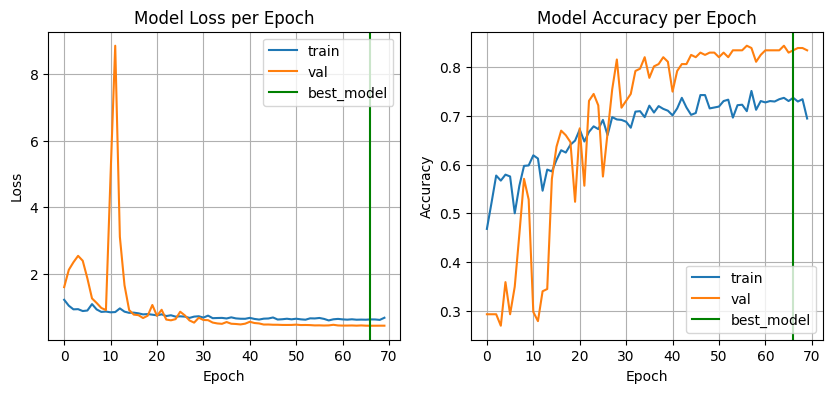

Validation Metrics:
Accuracy:  0.8349
Precision: 0.8375
Recall:    0.8349
F1 Score:  0.8339

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.68      0.73        62
           1       0.71      0.81      0.75        57
           2       0.95      0.93      0.94        45
           3       0.94      0.98      0.96        48

    accuracy                           0.83       212
   macro avg       0.85      0.85      0.85       212
weighted avg       0.84      0.83      0.83       212

[[42 18  1  1]
 [11 46  0  0]
 [ 0  1 42  2]
 [ 0  0  1 47]]


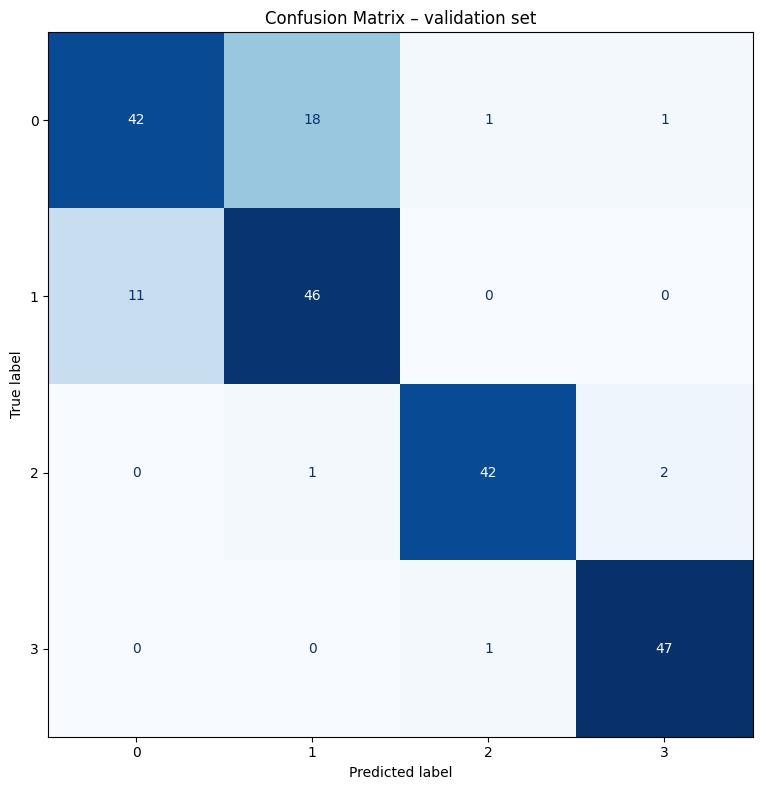

<Figure size 800x800 with 0 Axes>

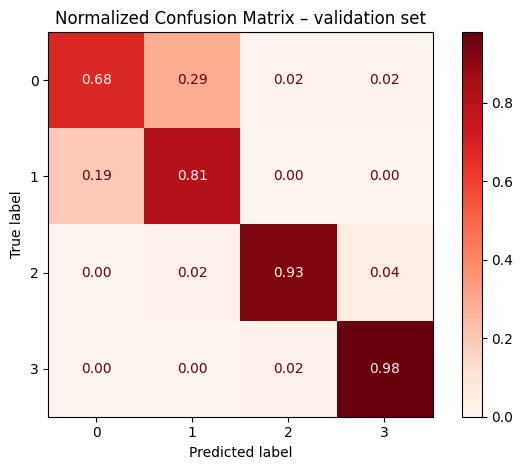

In [ ]:
inputs = Input(shape=(64,64,1))

x = conv_block(inputs, filters=64)

x = res_block(x, filters=64)
x = res_block(x, filters=64)
x = res_block(x, filters=128)
x = res_block(x, filters=256)
x = GlobalAveragePooling2D()(x)
x = dense_block(x, units=256, dropout=0.3)
x = dense_block(x, units=128, dropout=0.3)
x = dense_block(x, units=64, dropout=0.3)
outputs = Dense(units=4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

batch_size=16
max_epochs=70

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                   patience=3, verbose=1)

save_model = ModelCheckpoint('best_model_5.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=0)

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#train
history_5 = model.fit(x_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(x_val, y_val),
                    shuffle = True, verbose=2,
                    callbacks=[save_model, lr_scheduler])
#plot loss/accuracy
best_epoch = int(np.argmin(history_5.history['val_loss']))
best_val_acc = history_5.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")

#plots
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(history_5.history['loss'])
plt.plot(history_5.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='upper right')
plt.grid()

plt.subplot(122)
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='lower right')
plt.grid()
plt.show()

#predict
y_pred_probs = model.predict(x_val, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

#metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


#confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

#confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# **CNN Model 8 (from CNN 5)**

 **Data augmentation to the custom network that gave the best results**

Epoch 1/70


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 - 21s - 314ms/step - accuracy: 0.4367 - loss: 1.2359 - val_accuracy: 0.3221 - val_loss: 1.5465 - learning_rate: 1.0000e-03
Epoch 2/70


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


66/66 - 0s - 4ms/step - accuracy: 0.5625 - loss: 1.0847 - val_accuracy: 0.3221 - val_loss: 1.5511 - learning_rate: 1.0000e-03
Epoch 3/70
66/66 - 5s - 79ms/step - accuracy: 0.5403 - loss: 1.0537 - val_accuracy: 0.2692 - val_loss: 2.0035 - learning_rate: 1.0000e-03
Epoch 4/70
66/66 - 0s - 4ms/step - accuracy: 0.5000 - loss: 1.0758 - val_accuracy: 0.2692 - val_loss: 1.9984 - learning_rate: 1.0000e-03
Epoch 5/70
66/66 - 8s - 118ms/step - accuracy: 0.5662 - loss: 0.9627 - val_accuracy: 0.2692 - val_loss: 2.5213 - learning_rate: 1.0000e-03
Epoch 6/70

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 - 0s - 4ms/step - accuracy: 0.5625 - loss: 0.7363 - val_accuracy: 0.2692 - val_loss: 2.5244 - learning_rate: 1.0000e-03
Epoch 7/70
66/66 - 3s - 47ms/step - accuracy: 0.5691 - loss: 0.9280 - val_accuracy: 0.2692 - val_loss: 2.7139 - learning_rate: 5.0000e-04
Epoch 8/70
66/66 - 0s - 4ms/step - accuracy: 0.6875 - loss: 0.7695 - val_accuracy: 0.2692 - val_loss: 2.7077

66/66 - 5s - 74ms/step - accuracy: 0.6488 - loss: 0.7816 - val_accuracy: 0.3750 - val_loss: 1.1728 - learning_rate: 1.2500e-04
Epoch 18/70


66/66 - 0s - 5ms/step - accuracy: 0.8125 - loss: 0.5020 - val_accuracy: 0.3750 - val_loss: 1.1706 - learning_rate: 1.2500e-04
Epoch 19/70


66/66 - 5s - 79ms/step - accuracy: 0.6516 - loss: 0.7629 - val_accuracy: 0.4712 - val_loss: 1.0616 - learning_rate: 1.2500e-04
Epoch 20/70


66/66 - 0s - 6ms/step - accuracy: 0.6250 - loss: 0.6196 - val_accuracy: 0.4712 - val_loss: 1.0525 - learning_rate: 1.2500e-04
Epoch 21/70


66/66 - 3s - 45ms/step - accuracy: 0.6497 - loss: 0.7554 - val_accuracy: 0.6394 - val_loss: 0.7536 - learning_rate: 1.2500e-04
Epoch 22/70


66/66 - 0s - 5ms/step - accuracy: 0.5625 - loss: 0.7987 - val_accuracy: 0.6394 - val_loss: 0.7520 - learning_rate: 1.2500e-04
Epoch 23/70


66/66 - 3s - 45ms/step - accuracy: 0.6804 - loss: 0.7391 - val_accuracy: 0.7163 - val_loss: 0.7254 - learning_rate: 1.2500e-04
Epoch 24/70


66/66 - 0s - 5ms/step - accuracy: 0.5000 - loss: 1.0533 - val_accuracy: 0.7308 - val_loss: 0.7125 - learning_rate: 1.2500e-04
Epoch 25/70
66/66 - 5s - 71ms/step - accuracy: 0.6603 - loss: 0.7486 - val_accuracy: 0.6442 - val_loss: 0.7506 - learning_rate: 1.2500e-04
Epoch 26/70
66/66 - 0s - 4ms/step - accuracy: 0.5000 - loss: 0.7869 - val_accuracy: 0.6635 - val_loss: 0.7293 - learning_rate: 1.2500e-04
Epoch 27/70


66/66 - 5s - 75ms/step - accuracy: 0.6727 - loss: 0.7238 - val_accuracy: 0.7452 - val_loss: 0.6059 - learning_rate: 1.2500e-04
Epoch 28/70
66/66 - 1s - 8ms/step - accuracy: 0.8125 - loss: 0.6713 - val_accuracy: 0.7452 - val_loss: 0.6093 - learning_rate: 1.2500e-04
Epoch 29/70
66/66 - 3s - 43ms/step - accuracy: 0.6871 - loss: 0.7020 - val_accuracy: 0.7019 - val_loss: 0.6265 - learning_rate: 1.2500e-04
Epoch 30/70
66/66 - 0s - 5ms/step - accuracy: 0.7500 - loss: 0.6237 - val_accuracy: 0.7212 - val_loss: 0.6209 - learning_rate: 1.2500e-04
Epoch 31/70
66/66 - 3s - 44ms/step - accuracy: 0.6785 - loss: 0.6992 - val_accuracy: 0.6875 - val_loss: 0.8575 - learning_rate: 1.2500e-04
Epoch 32/70

Epoch 32: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
66/66 - 0s - 4ms/step - accuracy: 0.8125 - loss: 0.4489 - val_accuracy: 0.7067 - val_loss: 0.7933 - learning_rate: 1.2500e-04
Epoch 33/70
66/66 - 3s - 43ms/step - accuracy: 0.6862 - loss: 0.6831 - val_accuracy: 0.7260 - val_loss: 

66/66 - 5s - 79ms/step - accuracy: 0.7294 - loss: 0.6322 - val_accuracy: 0.7692 - val_loss: 0.5736 - learning_rate: 3.1250e-05
Epoch 42/70


66/66 - 0s - 6ms/step - accuracy: 0.6250 - loss: 0.8217 - val_accuracy: 0.7692 - val_loss: 0.5709 - learning_rate: 3.1250e-05
Epoch 43/70
66/66 - 3s - 45ms/step - accuracy: 0.7351 - loss: 0.6328 - val_accuracy: 0.7019 - val_loss: 0.6788 - learning_rate: 3.1250e-05
Epoch 44/70
66/66 - 0s - 5ms/step - accuracy: 0.8750 - loss: 0.3945 - val_accuracy: 0.6779 - val_loss: 0.7005 - learning_rate: 3.1250e-05
Epoch 45/70


66/66 - 5s - 79ms/step - accuracy: 0.7339 - loss: 0.6305 - val_accuracy: 0.7837 - val_loss: 0.5499 - learning_rate: 3.1250e-05
Epoch 46/70


66/66 - 0s - 5ms/step - accuracy: 1.0000 - loss: 0.2986 - val_accuracy: 0.7837 - val_loss: 0.5495 - learning_rate: 3.1250e-05
Epoch 47/70
66/66 - 5s - 77ms/step - accuracy: 0.7495 - loss: 0.6113 - val_accuracy: 0.7212 - val_loss: 0.6345 - learning_rate: 3.1250e-05
Epoch 48/70
66/66 - 1s - 8ms/step - accuracy: 0.8750 - loss: 0.4244 - val_accuracy: 0.7260 - val_loss: 0.6387 - learning_rate: 3.1250e-05
Epoch 49/70


66/66 - 8s - 119ms/step - accuracy: 0.7390 - loss: 0.6293 - val_accuracy: 0.7837 - val_loss: 0.5442 - learning_rate: 3.1250e-05
Epoch 50/70
66/66 - 0s - 7ms/step - accuracy: 0.3750 - loss: 1.0338 - val_accuracy: 0.7837 - val_loss: 0.5446 - learning_rate: 3.1250e-05
Epoch 51/70


66/66 - 5s - 68ms/step - accuracy: 0.7284 - loss: 0.6332 - val_accuracy: 0.8077 - val_loss: 0.5388 - learning_rate: 3.1250e-05
Epoch 52/70


66/66 - 0s - 6ms/step - accuracy: 0.8125 - loss: 0.4944 - val_accuracy: 0.8077 - val_loss: 0.5382 - learning_rate: 3.1250e-05
Epoch 53/70
66/66 - 5s - 70ms/step - accuracy: 0.7322 - loss: 0.6225 - val_accuracy: 0.7692 - val_loss: 0.5467 - learning_rate: 3.1250e-05
Epoch 54/70
66/66 - 0s - 5ms/step - accuracy: 0.7500 - loss: 0.6127 - val_accuracy: 0.7692 - val_loss: 0.5499 - learning_rate: 3.1250e-05
Epoch 55/70


66/66 - 3s - 48ms/step - accuracy: 0.7418 - loss: 0.6009 - val_accuracy: 0.8413 - val_loss: 0.5268 - learning_rate: 3.1250e-05
Epoch 56/70
66/66 - 0s - 7ms/step - accuracy: 0.7500 - loss: 0.4899 - val_accuracy: 0.8413 - val_loss: 0.5287 - learning_rate: 3.1250e-05
Epoch 57/70
66/66 - 3s - 45ms/step - accuracy: 0.7370 - loss: 0.6174 - val_accuracy: 0.7692 - val_loss: 0.5631 - learning_rate: 3.1250e-05
Epoch 58/70
66/66 - 0s - 5ms/step - accuracy: 0.8750 - loss: 0.4356 - val_accuracy: 0.7644 - val_loss: 0.5639 - learning_rate: 3.1250e-05
Epoch 59/70


66/66 - 5s - 79ms/step - accuracy: 0.7495 - loss: 0.5836 - val_accuracy: 0.8077 - val_loss: 0.5125 - learning_rate: 3.1250e-05
Epoch 60/70
66/66 - 1s - 8ms/step - accuracy: 0.6250 - loss: 0.8139 - val_accuracy: 0.8125 - val_loss: 0.5143 - learning_rate: 3.1250e-05
Epoch 61/70


66/66 - 5s - 80ms/step - accuracy: 0.7630 - loss: 0.5940 - val_accuracy: 0.8221 - val_loss: 0.5122 - learning_rate: 3.1250e-05
Epoch 62/70
66/66 - 0s - 4ms/step - accuracy: 0.8750 - loss: 0.3687 - val_accuracy: 0.8125 - val_loss: 0.5132 - learning_rate: 3.1250e-05
Epoch 63/70


66/66 - 3s - 46ms/step - accuracy: 0.7514 - loss: 0.5823 - val_accuracy: 0.8269 - val_loss: 0.5053 - learning_rate: 3.1250e-05
Epoch 64/70
66/66 - 0s - 7ms/step - accuracy: 0.8750 - loss: 0.3853 - val_accuracy: 0.8317 - val_loss: 0.5057 - learning_rate: 3.1250e-05
Epoch 65/70


66/66 - 5s - 70ms/step - accuracy: 0.7543 - loss: 0.5725 - val_accuracy: 0.8269 - val_loss: 0.5028 - learning_rate: 3.1250e-05
Epoch 66/70
66/66 - 0s - 8ms/step - accuracy: 0.5000 - loss: 0.7252 - val_accuracy: 0.8269 - val_loss: 0.5042 - learning_rate: 3.1250e-05
Epoch 67/70
66/66 - 4s - 68ms/step - accuracy: 0.7572 - loss: 0.5699 - val_accuracy: 0.7596 - val_loss: 0.5375 - learning_rate: 3.1250e-05
Epoch 68/70
66/66 - 0s - 5ms/step - accuracy: 0.4375 - loss: 0.8196 - val_accuracy: 0.7596 - val_loss: 0.5376 - learning_rate: 3.1250e-05
Epoch 69/70
66/66 - 5s - 73ms/step - accuracy: 0.7668 - loss: 0.5591 - val_accuracy: 0.7596 - val_loss: 0.5470 - learning_rate: 3.1250e-05
Epoch 70/70

Epoch 70: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
66/66 - 0s - 5ms/step - accuracy: 0.8125 - loss: 0.5222 - val_accuracy: 0.7548 - val_loss: 0.5559 - learning_rate: 3.1250e-05
Validation Accuracy at Best Epoch (64): 82.69%


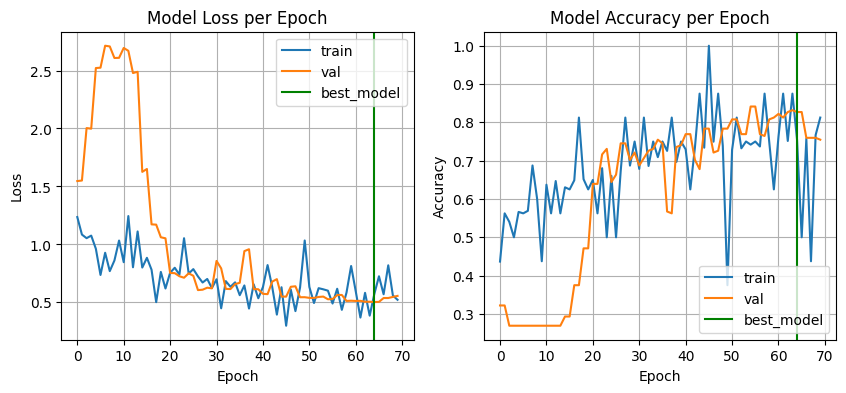

Validation Metrics:
Accuracy:  0.7547
Precision: 0.7849
Recall:    0.7547
F1 Score:  0.7494

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.50      0.62        62
           1       0.60      0.91      0.73        57
           2       0.87      0.76      0.81        45
           3       0.88      0.90      0.89        48

    accuracy                           0.75       212
   macro avg       0.79      0.77      0.76       212
weighted avg       0.78      0.75      0.75       212

[[31 29  1  1]
 [ 3 52  1  1]
 [ 2  5 34  4]
 [ 2  0  3 43]]


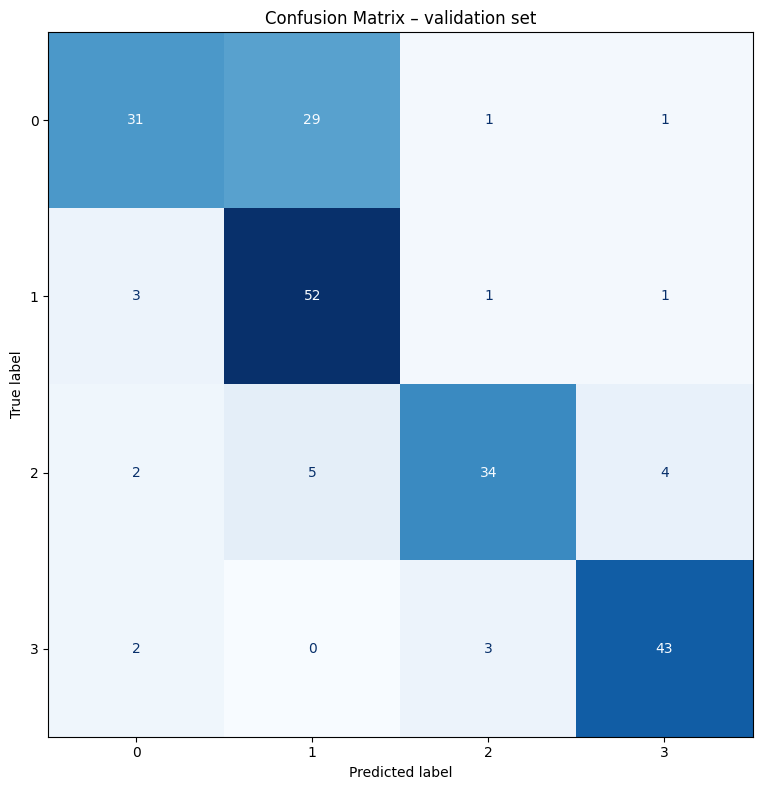

<Figure size 800x800 with 0 Axes>

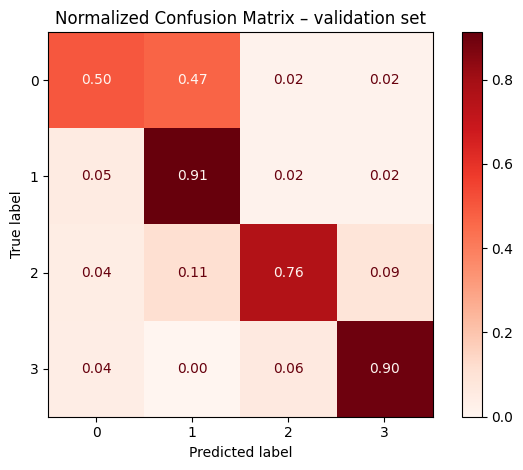

In [ ]:
inputs = Input(shape=(64,64,1))

x = conv_block(inputs, filters=64)
x = res_block(x, filters=64)
x = res_block(x, filters=64)
x = res_block(x, filters=128)
x = res_block(x, filters=256)
x = GlobalAveragePooling2D()(x)
x = dense_block(x, units=256, dropout=0.3)
x = dense_block(x, units=128, dropout=0.3)
x = dense_block(x, units=64, dropout=0.3)
outputs = Dense(units=4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

batch_size = 16
max_epochs = 70

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1
)

save_model = ModelCheckpoint(
    'best_model_8.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=0
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=0.5,
    width_shift_range=0.03,
    height_shift_range=0.03,
    #zoom_range=0.03,
)

val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=False)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size, shuffle=False)

#train
history_8 = model.fit(
    train_generator,
    steps_per_epoch=len(x_train)//batch_size,
    epochs=max_epochs,
    validation_data=val_generator,
    validation_steps=len(x_val)//batch_size,
    callbacks=[save_model, lr_scheduler],
    verbose=2
)


#plot loss/accuracy
best_epoch = int(np.argmin(history_8.history['val_loss']))
best_val_acc = history_8.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")

#plots
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(history_8.history['loss'])
plt.plot(history_8.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='upper right')
plt.grid()

plt.subplot(122)
plt.plot(history_8.history['accuracy'])
plt.plot(history_8.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Model Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best_model'], loc='lower right')
plt.grid()
plt.show()

#predict
y_pred_probs = model.predict(x_val, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

# metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


# confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()


# **Transfer learning (at least 2) ResNet, VGG**

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

#split x_train into training-validation
x_train_n, x_val, y_train_n, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

def resize_and_rgb(images, size=(224,224)):
    images_resized = tf.image.resize(images, size)
    images_rgb = tf.image.grayscale_to_rgb(images_resized)
    return images_rgb

#adding channel if missing for train and val
if len(x_train_n.shape) == 3:
    x_train_n = np.expand_dims(x_train_n, axis=-1)
if len(x_val.shape) == 3:
    x_val = np.expand_dims(x_val, axis=-1)

x_train_n = resize_and_rgb(x_train_n)
x_val = resize_and_rgb(x_val)
x_test = resize_and_rgb(x_test)

print("x_train_n shape:", x_train_n.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)


x_train_n shape: (952, 224, 224, 3)
x_val shape: (106, 224, 224, 3)
x_test shape: (118, 224, 224, 3)


# **Model 6**
**Transfer learning - petrained VGG16 model**

In [ ]:
#preprocess for VGG
x_train_vgg = vgg_preprocess(x_train_n * 255.0)
x_val_vgg = vgg_preprocess(x_val * 255.0)
x_test_vgg = vgg_preprocess(x_test * 255.0)
num_classes = y_train_n.shape[1]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/40

Epoch 1: val_loss improved from inf to 0.47622, saving model to best_model_6.h5


30/30 - 46s - 2s/step - accuracy: 0.2836 - loss: 0.8350 - val_accuracy: 0.5094 - val_loss: 0.4762 - learning_rate: 1.0000e-04
Epoch 2/40

Epoch 2: val_loss improved from 0.47622 to 0.38896, saving model to best_model_6.h5


30/30 - 43s - 1s/step - accuracy: 0.4632 - loss: 0.6217 - val_accuracy: 0.6509 - val_loss: 0.3890 - learning_rate: 1.0000e-04
Epoch 3/40

Epoch 3: val_loss improved from 0.38896 to 0.35753, saving model to best_model_6.h5


30/30 - 7s - 237ms/step - accuracy: 0.5630 - loss: 0.5206 - val_accuracy: 0.6887 - val_loss: 0.3575 - learning_rate: 1.0000e-04
Epoch 4/40

Epoch 4: val_loss improved from 0.35753 to 0.33086, saving model to best_model_6.h5


30/30 - 11s - 355ms/step - accuracy: 0.5914 - loss: 0.4836 - val_accuracy: 0.7264 - val_loss: 0.3309 - learning_rate: 1.0000e-04
Epoch 5/40

Epoch 5: val_loss improved from 0.33086 to 0.32454, saving model to best_model_6.h5


30/30 - 10s - 343ms/step - accuracy: 0.6282 - loss: 0.4524 - val_accuracy: 0.7170 - val_loss: 0.3245 - learning_rate: 1.0000e-04
Epoch 6/40

Epoch 6: val_loss improved from 0.32454 to 0.31075, saving model to best_model_6.h5


30/30 - 9s - 311ms/step - accuracy: 0.6628 - loss: 0.4138 - val_accuracy: 0.7358 - val_loss: 0.3108 - learning_rate: 1.0000e-04
Epoch 7/40

Epoch 7: val_loss improved from 0.31075 to 0.30973, saving model to best_model_6.h5


30/30 - 10s - 332ms/step - accuracy: 0.6765 - loss: 0.4048 - val_accuracy: 0.7170 - val_loss: 0.3097 - learning_rate: 1.0000e-04
Epoch 8/40

Epoch 8: val_loss improved from 0.30973 to 0.29764, saving model to best_model_6.h5


30/30 - 10s - 337ms/step - accuracy: 0.7143 - loss: 0.3514 - val_accuracy: 0.7736 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 9/40

Epoch 9: val_loss improved from 0.29764 to 0.29577, saving model to best_model_6.h5


30/30 - 10s - 341ms/step - accuracy: 0.7153 - loss: 0.3588 - val_accuracy: 0.7736 - val_loss: 0.2958 - learning_rate: 1.0000e-04
Epoch 10/40

Epoch 10: val_loss improved from 0.29577 to 0.29472, saving model to best_model_6.h5


30/30 - 6s - 211ms/step - accuracy: 0.7080 - loss: 0.3530 - val_accuracy: 0.7736 - val_loss: 0.2947 - learning_rate: 1.0000e-04
Epoch 11/40

Epoch 11: val_loss improved from 0.29472 to 0.29016, saving model to best_model_6.h5


30/30 - 6s - 216ms/step - accuracy: 0.7447 - loss: 0.3279 - val_accuracy: 0.7642 - val_loss: 0.2902 - learning_rate: 1.0000e-04
Epoch 12/40

Epoch 12: val_loss did not improve from 0.29016
30/30 - 11s - 356ms/step - accuracy: 0.7458 - loss: 0.3138 - val_accuracy: 0.7642 - val_loss: 0.2932 - learning_rate: 1.0000e-04
Epoch 13/40

Epoch 13: val_loss improved from 0.29016 to 0.28600, saving model to best_model_6.h5


30/30 - 10s - 327ms/step - accuracy: 0.7321 - loss: 0.3209 - val_accuracy: 0.7547 - val_loss: 0.2860 - learning_rate: 1.0000e-04
Epoch 14/40

Epoch 14: val_loss improved from 0.28600 to 0.28352, saving model to best_model_6.h5


30/30 - 7s - 220ms/step - accuracy: 0.7595 - loss: 0.3080 - val_accuracy: 0.7642 - val_loss: 0.2835 - learning_rate: 1.0000e-04
Epoch 15/40

Epoch 15: val_loss did not improve from 0.28352
30/30 - 10s - 334ms/step - accuracy: 0.7553 - loss: 0.3060 - val_accuracy: 0.7642 - val_loss: 0.2843 - learning_rate: 1.0000e-04
Epoch 16/40

Epoch 16: val_loss improved from 0.28352 to 0.27421, saving model to best_model_6.h5


30/30 - 10s - 346ms/step - accuracy: 0.7962 - loss: 0.2835 - val_accuracy: 0.7830 - val_loss: 0.2742 - learning_rate: 1.0000e-04
Epoch 17/40

Epoch 17: val_loss improved from 0.27421 to 0.27410, saving model to best_model_6.h5


30/30 - 10s - 337ms/step - accuracy: 0.7773 - loss: 0.2905 - val_accuracy: 0.7925 - val_loss: 0.2741 - learning_rate: 1.0000e-04
Epoch 18/40

Epoch 18: val_loss improved from 0.27410 to 0.27303, saving model to best_model_6.h5


30/30 - 7s - 217ms/step - accuracy: 0.7773 - loss: 0.2851 - val_accuracy: 0.7925 - val_loss: 0.2730 - learning_rate: 1.0000e-04
Epoch 19/40

Epoch 19: val_loss did not improve from 0.27303
30/30 - 10s - 335ms/step - accuracy: 0.7752 - loss: 0.2852 - val_accuracy: 0.7925 - val_loss: 0.2738 - learning_rate: 1.0000e-04
Epoch 20/40

Epoch 20: val_loss did not improve from 0.27303
30/30 - 11s - 361ms/step - accuracy: 0.7857 - loss: 0.2701 - val_accuracy: 0.7925 - val_loss: 0.2734 - learning_rate: 1.0000e-04
Epoch 21/40

Epoch 21: val_loss did not improve from 0.27303

Epoch 21: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
30/30 - 6s - 212ms/step - accuracy: 0.7805 - loss: 0.2692 - val_accuracy: 0.7925 - val_loss: 0.2737 - learning_rate: 1.0000e-04
Epoch 22/40

Epoch 22: val_loss did not improve from 0.27303
30/30 - 6s - 214ms/step - accuracy: 0.8057 - loss: 0.2626 - val_accuracy: 0.8113 - val_loss: 0.2735 - learning_rate: 5.0000e-05
Epoch 23/40

Epoch 23: val_loss impr

30/30 - 10s - 343ms/step - accuracy: 0.8015 - loss: 0.2617 - val_accuracy: 0.7925 - val_loss: 0.2690 - learning_rate: 5.0000e-05
Epoch 24/40

Epoch 24: val_loss did not improve from 0.26897
30/30 - 10s - 333ms/step - accuracy: 0.7815 - loss: 0.2620 - val_accuracy: 0.7925 - val_loss: 0.2699 - learning_rate: 5.0000e-05
Epoch 25/40

Epoch 25: val_loss did not improve from 0.26897
30/30 - 10s - 339ms/step - accuracy: 0.7983 - loss: 0.2588 - val_accuracy: 0.7925 - val_loss: 0.2718 - learning_rate: 5.0000e-05
Epoch 26/40

Epoch 26: val_loss did not improve from 0.26897

Epoch 26: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
30/30 - 10s - 343ms/step - accuracy: 0.7899 - loss: 0.2655 - val_accuracy: 0.8019 - val_loss: 0.2738 - learning_rate: 5.0000e-05
Epoch 27/40

Epoch 27: val_loss did not improve from 0.26897
30/30 - 10s - 342ms/step - accuracy: 0.8225 - loss: 0.2482 - val_accuracy: 0.8208 - val_loss: 0.2737 - learning_rate: 2.5000e-05
Epoch 28/40

Epoch 28: val_loss d

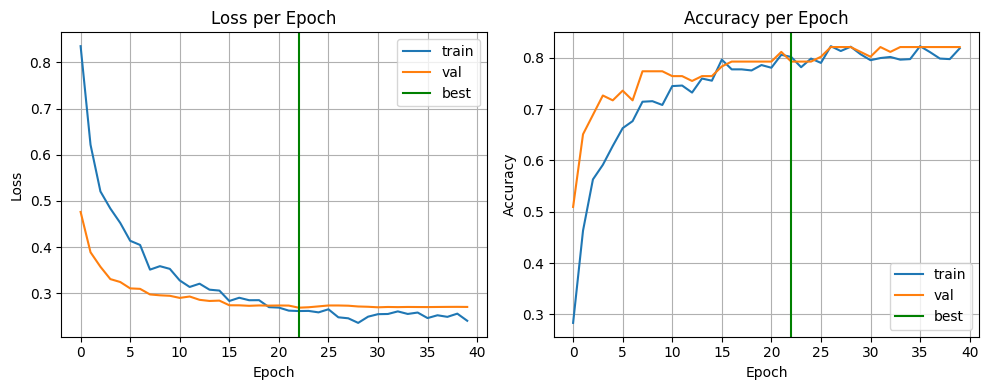

Validation Metrics:
Accuracy:  0.8208
Precision: 0.8305
Recall:    0.8208
F1 Score:  0.8243

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62        21
           1       0.91      0.84      0.87        37
           2       0.90      0.86      0.88        21
           3       0.86      0.89      0.87        27

    accuracy                           0.82       106
   macro avg       0.81      0.81      0.81       106
weighted avg       0.83      0.82      0.82       106

[[14  3  1  3]
 [ 6 31  0  0]
 [ 2  0 18  1]
 [ 2  0  1 24]]


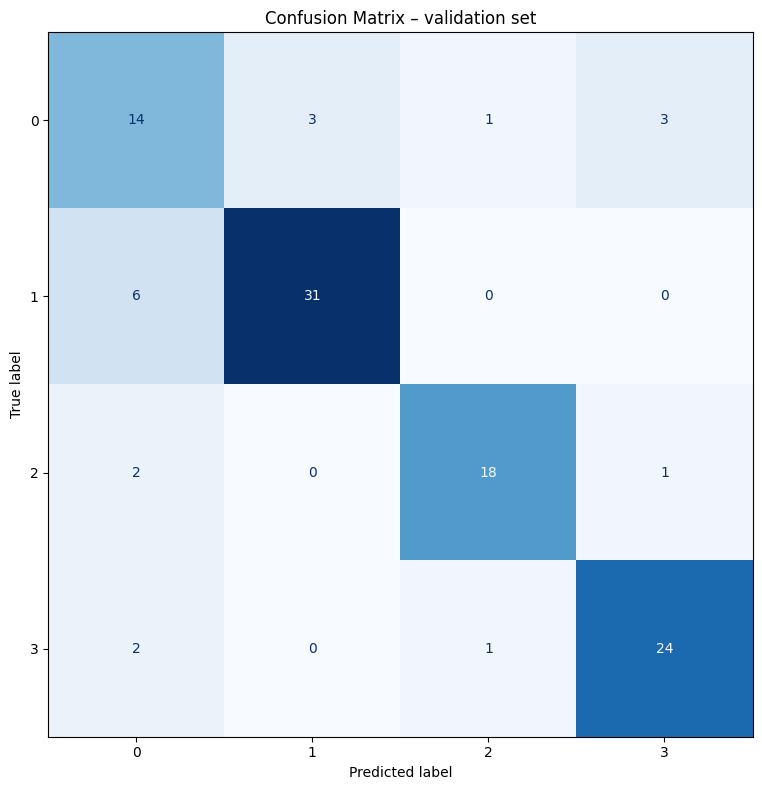

<Figure size 800x800 with 0 Axes>

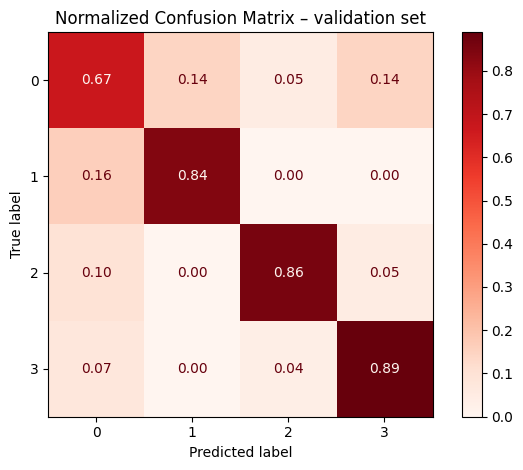

In [ ]:
base_vgg_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3))

#i need to freeze the model
base_vgg_model.trainable = False


#head
inputs = keras.Input(shape=(224, 224, 3))
x = base_vgg_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)


vgg_model = keras.Model(inputs,outputs)

epochs= 40
batch_size= 16
save_model = ModelCheckpoint('best_model_6.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

vgg_model.compile(
    loss='binary_crossentropy',
    optimizer= keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

#train
history_6 = vgg_model.fit(
    x_train_vgg, y_train_n,
    validation_data=(x_val_vgg, y_val),
    epochs=epochs,
    batch_size=32,
    shuffle=True,
    verbose=2,
    callbacks=[save_model, lr_scheduler]
)

print("Evaluating on test set...")
test_loss, test_acc = vgg_model.evaluate(x_test_vgg, y_test, verbose=0)
print(f"VGG16 Test Accuracy: {test_acc*100:.2f}%")



#plot loss/accuracy
best_epoch = int(np.argmin(history_6.history['val_loss']))
best_val_acc = history_6.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Loss per Epoch')
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best'], loc='upper right'); plt.grid()

plt.subplot(1,2,2)
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Accuracy per Epoch')
plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best'], loc='lower right'); plt.grid()
plt.tight_layout(); plt.show()

#predict
y_pred_probs = vgg_model.predict(x_val_vgg, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

# metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


# confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# **Model 7**
**Transfer learning - ResNet50**

In [ ]:
#preprocess for ResNet


x_train_resnet = resnet_preprocess(x_train_n * 255.0)
x_val_resnet = resnet_preprocess(x_val * 255.0)
x_test_resnet = resnet_preprocess(x_test * 255.0)

num_classes = y_train_n.shape[1]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20

Epoch 1: val_loss improved from inf to 0.70989, saving model to best_model_7.h5


30/30 - 36s - 1s/step - accuracy: 0.4076 - loss: 1.4694 - val_accuracy: 0.6698 - val_loss: 0.7099
Epoch 2/20

Epoch 2: val_loss improved from 0.70989 to 0.61044, saving model to best_model_7.h5


30/30 - 4s - 135ms/step - accuracy: 0.6544 - loss: 0.7999 - val_accuracy: 0.7453 - val_loss: 0.6104
Epoch 3/20

Epoch 3: val_loss improved from 0.61044 to 0.60598, saving model to best_model_7.h5


30/30 - 4s - 123ms/step - accuracy: 0.7521 - loss: 0.6309 - val_accuracy: 0.7453 - val_loss: 0.6060
Epoch 4/20

Epoch 4: val_loss improved from 0.60598 to 0.58690, saving model to best_model_7.h5


30/30 - 4s - 124ms/step - accuracy: 0.7647 - loss: 0.5559 - val_accuracy: 0.7453 - val_loss: 0.5869
Epoch 5/20

Epoch 5: val_loss improved from 0.58690 to 0.56400, saving model to best_model_7.h5


30/30 - 5s - 182ms/step - accuracy: 0.7805 - loss: 0.5452 - val_accuracy: 0.7925 - val_loss: 0.5640
Epoch 6/20

Epoch 6: val_loss improved from 0.56400 to 0.56069, saving model to best_model_7.h5


30/30 - 4s - 130ms/step - accuracy: 0.8235 - loss: 0.4646 - val_accuracy: 0.7830 - val_loss: 0.5607
Epoch 7/20

Epoch 7: val_loss did not improve from 0.56069
30/30 - 3s - 104ms/step - accuracy: 0.8067 - loss: 0.4541 - val_accuracy: 0.7547 - val_loss: 0.5806
Epoch 8/20

Epoch 8: val_loss improved from 0.56069 to 0.54357, saving model to best_model_7.h5


30/30 - 4s - 135ms/step - accuracy: 0.8382 - loss: 0.3941 - val_accuracy: 0.8019 - val_loss: 0.5436
Epoch 9/20

Epoch 9: val_loss did not improve from 0.54357
30/30 - 4s - 138ms/step - accuracy: 0.8571 - loss: 0.3730 - val_accuracy: 0.7830 - val_loss: 0.5596
Epoch 10/20

Epoch 10: val_loss did not improve from 0.54357
30/30 - 5s - 168ms/step - accuracy: 0.8613 - loss: 0.3482 - val_accuracy: 0.7925 - val_loss: 0.5437
Epoch 11/20

Epoch 11: val_loss did not improve from 0.54357
30/30 - 5s - 171ms/step - accuracy: 0.8792 - loss: 0.3257 - val_accuracy: 0.7736 - val_loss: 0.5654
Epoch 12/20

Epoch 12: val_loss did not improve from 0.54357
30/30 - 5s - 178ms/step - accuracy: 0.8729 - loss: 0.3271 - val_accuracy: 0.7830 - val_loss: 0.5532
Epoch 13/20

Epoch 13: val_loss improved from 0.54357 to 0.51969, saving model to best_model_7.h5


30/30 - 5s - 181ms/step - accuracy: 0.8761 - loss: 0.3092 - val_accuracy: 0.8019 - val_loss: 0.5197
Epoch 14/20

Epoch 14: val_loss did not improve from 0.51969
30/30 - 3s - 100ms/step - accuracy: 0.8824 - loss: 0.2964 - val_accuracy: 0.8208 - val_loss: 0.5225
Epoch 15/20

Epoch 15: val_loss did not improve from 0.51969
30/30 - 5s - 171ms/step - accuracy: 0.8950 - loss: 0.2764 - val_accuracy: 0.8113 - val_loss: 0.5328
Epoch 16/20

Epoch 16: val_loss did not improve from 0.51969
30/30 - 6s - 183ms/step - accuracy: 0.9023 - loss: 0.2527 - val_accuracy: 0.8113 - val_loss: 0.5303
Epoch 17/20

Epoch 17: val_loss did not improve from 0.51969
30/30 - 5s - 158ms/step - accuracy: 0.8918 - loss: 0.2608 - val_accuracy: 0.8113 - val_loss: 0.5332
Epoch 18/20

Epoch 18: val_loss did not improve from 0.51969
30/30 - 5s - 182ms/step - accuracy: 0.9254 - loss: 0.2171 - val_accuracy: 0.7642 - val_loss: 0.5710
Epoch 19/20

Epoch 19: val_loss did not improve from 0.51969
30/30 - 3s - 104ms/step - accuracy

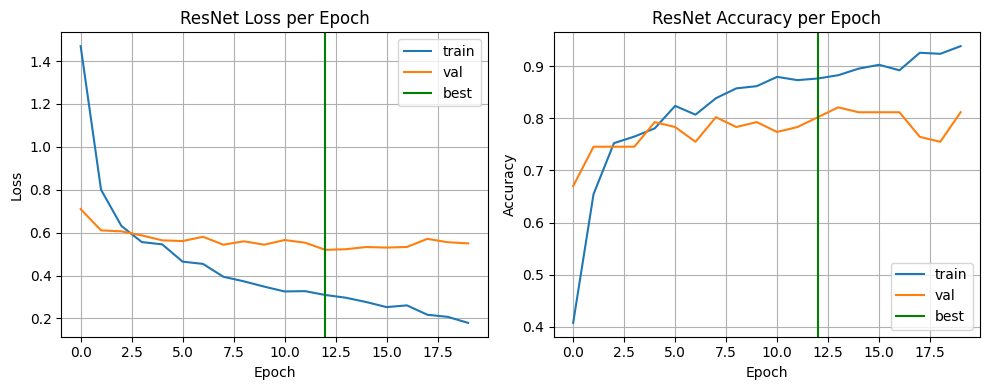

Validation Metrics:
Accuracy:  0.8113
Precision: 0.8175
Recall:    0.8113
F1 Score:  0.8097

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65        21
           1       0.82      0.86      0.84        37
           2       0.77      0.95      0.85        21
           3       0.95      0.78      0.86        27

    accuracy                           0.81       106
   macro avg       0.81      0.80      0.80       106
weighted avg       0.82      0.81      0.81       106

[[13  7  1  0]
 [ 5 32  0  0]
 [ 0  0 20  1]
 [ 1  0  5 21]]


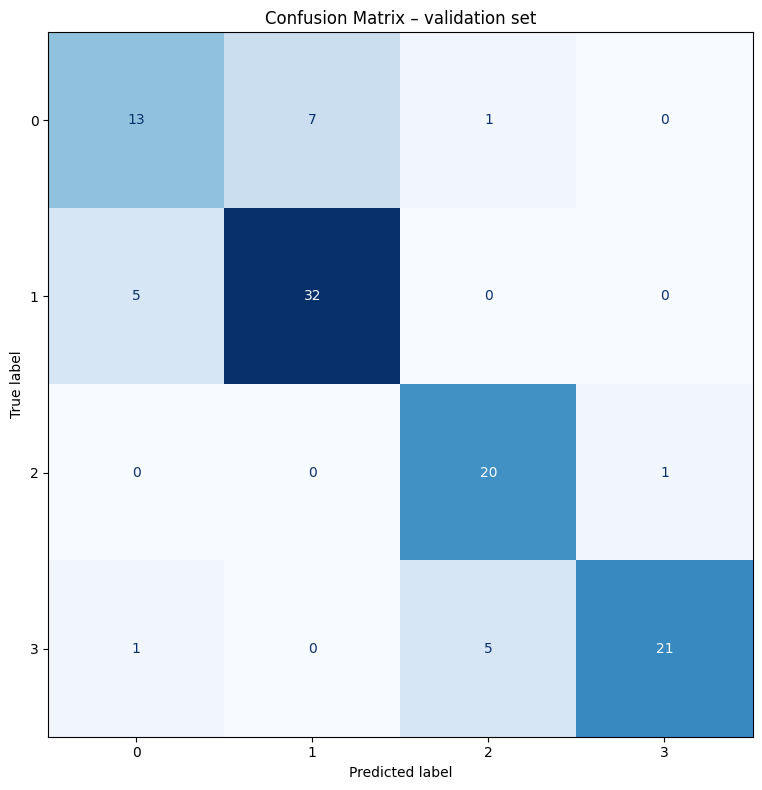

<Figure size 800x800 with 0 Axes>

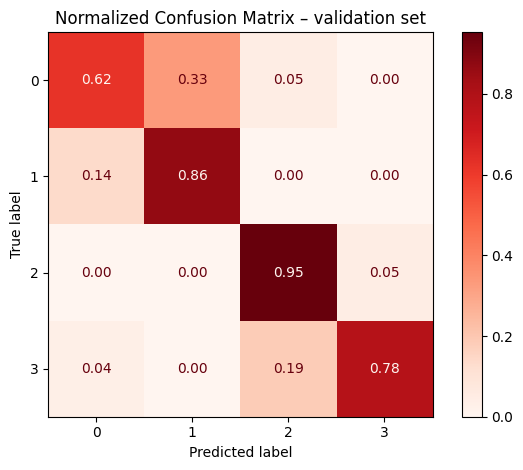

In [ ]:
base_resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
#need to freeze it
base_resnet.trainable = False

#head
inputs = keras.Input(shape=(224, 224, 3))
x = base_resnet(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

resnet_model = keras.Model(inputs, outputs)
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

save_model = ModelCheckpoint('best_model_7.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)


# train
history_7 = resnet_model.fit(
    x_train_resnet, y_train_n,
    validation_data=(x_val_resnet, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[save_model],
    verbose=2
)

test_loss, test_acc = resnet_model.evaluate(x_test_resnet, y_test, verbose=0)

#plot loss/accuracy
best_epoch = int(np.argmin(history_7.history['val_loss']))
best_val_acc = history_7.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")
plt.figure(figsize=(10,4))


#plots
plt.subplot(1,2,1)
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('ResNet Loss per Epoch')
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best'], loc='upper right'); plt.grid()

plt.subplot(1,2,2)
plt.plot(history_7.history['accuracy'])
plt.plot(history_7.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('ResNet Accuracy per Epoch')
plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best'], loc='lower right'); plt.grid()
plt.tight_layout(); plt.show()

#predict
y_pred_probs = resnet_model.predict(x_val_resnet, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

#metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


#confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

#confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()



# **CNN 9**

**Data augmentation + transfer learning VGG16 (model 6)**

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.41786, saving model to best_model_9.h5


60/60 - 17s - 277ms/step - accuracy: 0.3750 - loss: 0.7239 - val_accuracy: 0.6321 - val_loss: 0.4179 - learning_rate: 1.0000e-04
Epoch 2/40

Epoch 2: val_loss improved from 0.41786 to 0.36699, saving model to best_model_9.h5


60/60 - 5s - 91ms/step - accuracy: 0.5420 - loss: 0.5405 - val_accuracy: 0.6981 - val_loss: 0.3670 - learning_rate: 1.0000e-04
Epoch 3/40

Epoch 3: val_loss improved from 0.36699 to 0.33701, saving model to best_model_9.h5


60/60 - 10s - 170ms/step - accuracy: 0.6071 - loss: 0.4625 - val_accuracy: 0.6981 - val_loss: 0.3370 - learning_rate: 1.0000e-04
Epoch 4/40

Epoch 4: val_loss improved from 0.33701 to 0.32536, saving model to best_model_9.h5


60/60 - 10s - 168ms/step - accuracy: 0.6544 - loss: 0.4168 - val_accuracy: 0.7358 - val_loss: 0.3254 - learning_rate: 1.0000e-04
Epoch 5/40

Epoch 5: val_loss improved from 0.32536 to 0.31180, saving model to best_model_9.h5


60/60 - 10s - 172ms/step - accuracy: 0.6786 - loss: 0.4014 - val_accuracy: 0.7170 - val_loss: 0.3118 - learning_rate: 1.0000e-04
Epoch 6/40

Epoch 6: val_loss improved from 0.31180 to 0.30821, saving model to best_model_9.h5


60/60 - 10s - 169ms/step - accuracy: 0.6828 - loss: 0.3808 - val_accuracy: 0.7358 - val_loss: 0.3082 - learning_rate: 1.0000e-04
Epoch 7/40

Epoch 7: val_loss improved from 0.30821 to 0.30202, saving model to best_model_9.h5


60/60 - 10s - 167ms/step - accuracy: 0.6996 - loss: 0.3746 - val_accuracy: 0.7170 - val_loss: 0.3020 - learning_rate: 1.0000e-04
Epoch 8/40

Epoch 8: val_loss improved from 0.30202 to 0.29668, saving model to best_model_9.h5


60/60 - 10s - 172ms/step - accuracy: 0.7069 - loss: 0.3465 - val_accuracy: 0.7358 - val_loss: 0.2967 - learning_rate: 1.0000e-04
Epoch 9/40

Epoch 9: val_loss improved from 0.29668 to 0.29371, saving model to best_model_9.h5


60/60 - 10s - 170ms/step - accuracy: 0.7342 - loss: 0.3370 - val_accuracy: 0.7453 - val_loss: 0.2937 - learning_rate: 1.0000e-04
Epoch 10/40

Epoch 10: val_loss improved from 0.29371 to 0.29259, saving model to best_model_9.h5


60/60 - 5s - 91ms/step - accuracy: 0.7290 - loss: 0.3433 - val_accuracy: 0.7358 - val_loss: 0.2926 - learning_rate: 1.0000e-04
Epoch 11/40

Epoch 11: val_loss improved from 0.29259 to 0.29010, saving model to best_model_9.h5


60/60 - 10s - 170ms/step - accuracy: 0.7447 - loss: 0.3219 - val_accuracy: 0.7453 - val_loss: 0.2901 - learning_rate: 1.0000e-04
Epoch 12/40

Epoch 12: val_loss improved from 0.29010 to 0.28730, saving model to best_model_9.h5


60/60 - 10s - 169ms/step - accuracy: 0.7637 - loss: 0.3067 - val_accuracy: 0.7453 - val_loss: 0.2873 - learning_rate: 1.0000e-04
Epoch 13/40

Epoch 13: val_loss improved from 0.28730 to 0.28024, saving model to best_model_9.h5


60/60 - 5s - 90ms/step - accuracy: 0.7458 - loss: 0.2963 - val_accuracy: 0.7736 - val_loss: 0.2802 - learning_rate: 1.0000e-04
Epoch 14/40

Epoch 14: val_loss did not improve from 0.28024
60/60 - 5s - 87ms/step - accuracy: 0.7668 - loss: 0.2959 - val_accuracy: 0.7453 - val_loss: 0.2860 - learning_rate: 1.0000e-04
Epoch 15/40

Epoch 15: val_loss improved from 0.28024 to 0.27864, saving model to best_model_9.h5


60/60 - 10s - 170ms/step - accuracy: 0.7563 - loss: 0.3016 - val_accuracy: 0.7642 - val_loss: 0.2786 - learning_rate: 1.0000e-04
Epoch 16/40

Epoch 16: val_loss did not improve from 0.27864
60/60 - 10s - 167ms/step - accuracy: 0.7815 - loss: 0.2873 - val_accuracy: 0.7547 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 17/40

Epoch 17: val_loss improved from 0.27864 to 0.27833, saving model to best_model_9.h5


60/60 - 5s - 88ms/step - accuracy: 0.7857 - loss: 0.2819 - val_accuracy: 0.7642 - val_loss: 0.2783 - learning_rate: 1.0000e-04
Epoch 18/40

Epoch 18: val_loss did not improve from 0.27833
60/60 - 5s - 87ms/step - accuracy: 0.7815 - loss: 0.2752 - val_accuracy: 0.7642 - val_loss: 0.2796 - learning_rate: 1.0000e-04
Epoch 19/40

Epoch 19: val_loss did not improve from 0.27833
60/60 - 10s - 168ms/step - accuracy: 0.7710 - loss: 0.2809 - val_accuracy: 0.7642 - val_loss: 0.2794 - learning_rate: 1.0000e-04
Epoch 20/40

Epoch 20: val_loss improved from 0.27833 to 0.26955, saving model to best_model_9.h5


60/60 - 5s - 90ms/step - accuracy: 0.7868 - loss: 0.2773 - val_accuracy: 0.7925 - val_loss: 0.2696 - learning_rate: 1.0000e-04
Epoch 21/40

Epoch 21: val_loss did not improve from 0.26955
60/60 - 10s - 168ms/step - accuracy: 0.7794 - loss: 0.2765 - val_accuracy: 0.7830 - val_loss: 0.2720 - learning_rate: 1.0000e-04
Epoch 22/40

Epoch 22: val_loss improved from 0.26955 to 0.26579, saving model to best_model_9.h5


60/60 - 10s - 170ms/step - accuracy: 0.7857 - loss: 0.2774 - val_accuracy: 0.7642 - val_loss: 0.2658 - learning_rate: 1.0000e-04
Epoch 23/40

Epoch 23: val_loss improved from 0.26579 to 0.26416, saving model to best_model_9.h5


60/60 - 10s - 173ms/step - accuracy: 0.7700 - loss: 0.2742 - val_accuracy: 0.7830 - val_loss: 0.2642 - learning_rate: 1.0000e-04
Epoch 24/40

Epoch 24: val_loss did not improve from 0.26416
60/60 - 10s - 169ms/step - accuracy: 0.7784 - loss: 0.2640 - val_accuracy: 0.7736 - val_loss: 0.2725 - learning_rate: 1.0000e-04
Epoch 25/40

Epoch 25: val_loss did not improve from 0.26416
60/60 - 10s - 171ms/step - accuracy: 0.7994 - loss: 0.2608 - val_accuracy: 0.7830 - val_loss: 0.2692 - learning_rate: 1.0000e-04
Epoch 26/40

Epoch 26: val_loss improved from 0.26416 to 0.26103, saving model to best_model_9.h5


60/60 - 10s - 172ms/step - accuracy: 0.7973 - loss: 0.2630 - val_accuracy: 0.7925 - val_loss: 0.2610 - learning_rate: 1.0000e-04
Epoch 27/40

Epoch 27: val_loss did not improve from 0.26103
60/60 - 10s - 167ms/step - accuracy: 0.8151 - loss: 0.2473 - val_accuracy: 0.8113 - val_loss: 0.2657 - learning_rate: 1.0000e-04
Epoch 28/40

Epoch 28: val_loss did not improve from 0.26103
60/60 - 10s - 169ms/step - accuracy: 0.8088 - loss: 0.2490 - val_accuracy: 0.7736 - val_loss: 0.2722 - learning_rate: 1.0000e-04
Epoch 29/40

Epoch 29: val_loss did not improve from 0.26103

Epoch 29: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
60/60 - 5s - 86ms/step - accuracy: 0.8130 - loss: 0.2346 - val_accuracy: 0.7736 - val_loss: 0.2615 - learning_rate: 1.0000e-04
Epoch 30/40

Epoch 30: val_loss improved from 0.26103 to 0.25679, saving model to best_model_9.h5


60/60 - 5s - 89ms/step - accuracy: 0.8204 - loss: 0.2407 - val_accuracy: 0.7736 - val_loss: 0.2568 - learning_rate: 5.0000e-05
Epoch 31/40

Epoch 31: val_loss did not improve from 0.25679
60/60 - 10s - 168ms/step - accuracy: 0.7973 - loss: 0.2427 - val_accuracy: 0.7736 - val_loss: 0.2577 - learning_rate: 5.0000e-05
Epoch 32/40

Epoch 32: val_loss did not improve from 0.25679
60/60 - 10s - 168ms/step - accuracy: 0.8067 - loss: 0.2427 - val_accuracy: 0.7736 - val_loss: 0.2631 - learning_rate: 5.0000e-05
Epoch 33/40

Epoch 33: val_loss did not improve from 0.25679

Epoch 33: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
60/60 - 5s - 84ms/step - accuracy: 0.8036 - loss: 0.2420 - val_accuracy: 0.7736 - val_loss: 0.2584 - learning_rate: 5.0000e-05
Epoch 34/40

Epoch 34: val_loss did not improve from 0.25679
60/60 - 5s - 84ms/step - accuracy: 0.8130 - loss: 0.2328 - val_accuracy: 0.7642 - val_loss: 0.2605 - learning_rate: 2.5000e-05
Epoch 35/40

Epoch 35: val_loss did not

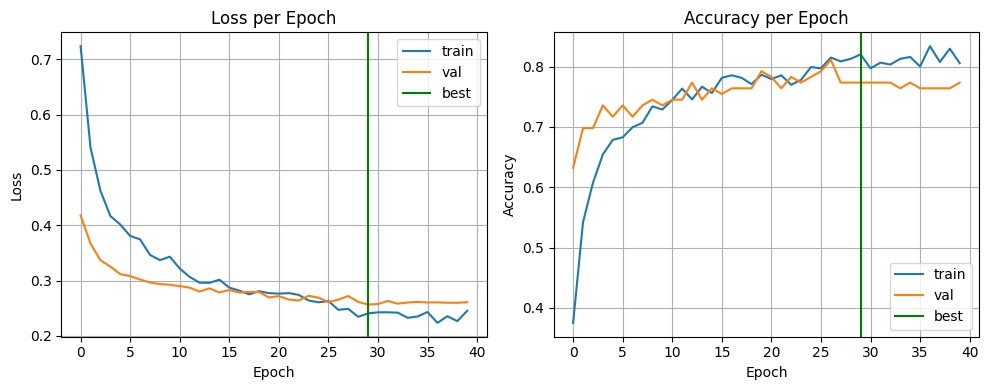

Validation Metrics:
Accuracy:  0.7736
Precision: 0.7936
Recall:    0.7736
F1 Score:  0.7788

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60        21
           1       0.86      0.81      0.83        37
           2       0.94      0.71      0.81        21
           3       0.79      0.85      0.82        27

    accuracy                           0.77       106
   macro avg       0.78      0.76      0.77       106
weighted avg       0.79      0.77      0.78       106

[[14  4  0  3]
 [ 7 30  0  0]
 [ 3  0 15  3]
 [ 2  1  1 23]]


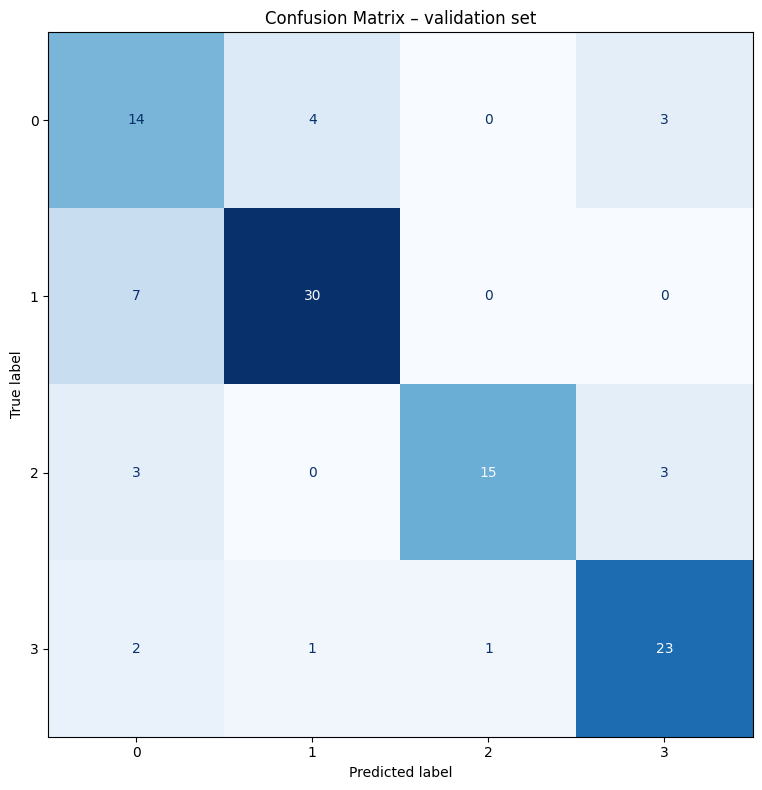

<Figure size 800x800 with 0 Axes>

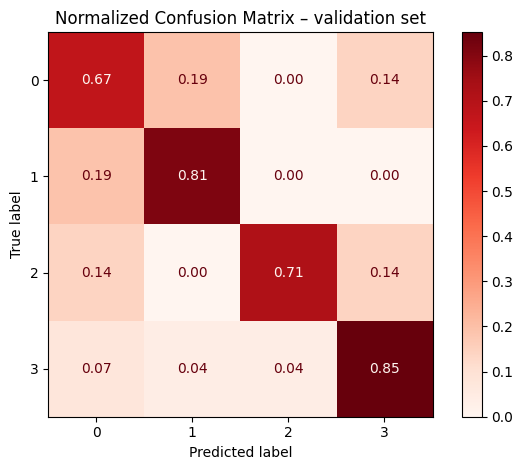

In [ ]:
#data augmentation layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    #keras.layers.RandomZoom(0.05),
    keras.layers.RandomTranslation(0.05, 0.05),
])

#base for vgg16
base_vgg_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_vgg_model.trainable = False

#head
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = vgg_preprocess(x * 255.0)
x = base_vgg_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(y_train_n.shape[1], activation='softmax')(x)

vgg_model = keras.Model(inputs, outputs)


save_model = ModelCheckpoint('best_model_9.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

vgg_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

#train
history_9 = vgg_model.fit(
    x_train_n, y_train_n,
    validation_data=(x_val, y_val),
    epochs=40,
    batch_size=16,
    shuffle=True,
    verbose=2,
    callbacks=[save_model, lr_schedule]
)

#evaluation
print("Evaluating on test set...")
test_loss, test_acc = vgg_model.evaluate(x_test, y_test, verbose=0)
print(f"VGG16 Test Accuracy: {test_acc*100:.2f}%")

#plot loss/accuracy
best_epoch = int(np.argmin(history_9.history['val_loss']))
best_val_acc = history_9.history['val_accuracy'][best_epoch]
print(f"Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")

#plots
best_epoch = int(np.argmin(history_9.history['val_loss']))
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_9.history['loss'])
plt.plot(history_9.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Loss per Epoch')
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best'], loc='upper right'); plt.grid()

plt.subplot(1,2,2)
plt.plot(history_9.history['accuracy'])
plt.plot(history_9.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('Accuracy per Epoch')
plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best'], loc='lower right'); plt.grid()
plt.tight_layout(); plt.show()

#predict
y_pred_probs = vgg_model.predict(x_val, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

#metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')


print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


#confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

#confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()


# **Model 10**

**Data augmentation+ Transfer learning - ResNet50 (model 7)**

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.75730, saving model to best_model_10.h5


30/30 - 31s - 1s/step - accuracy: 0.4947 - loss: 1.2863 - val_accuracy: 0.6698 - val_loss: 0.7573
Epoch 2/40

Epoch 2: val_loss improved from 0.75730 to 0.66373, saving model to best_model_10.h5


30/30 - 21s - 693ms/step - accuracy: 0.6870 - loss: 0.7555 - val_accuracy: 0.7170 - val_loss: 0.6637
Epoch 3/40

Epoch 3: val_loss improved from 0.66373 to 0.62494, saving model to best_model_10.h5


30/30 - 4s - 117ms/step - accuracy: 0.7458 - loss: 0.6088 - val_accuracy: 0.6792 - val_loss: 0.6249
Epoch 4/40

Epoch 4: val_loss did not improve from 0.62494
30/30 - 5s - 157ms/step - accuracy: 0.7700 - loss: 0.5449 - val_accuracy: 0.7453 - val_loss: 0.6403
Epoch 5/40

Epoch 5: val_loss improved from 0.62494 to 0.61039, saving model to best_model_10.h5


30/30 - 6s - 198ms/step - accuracy: 0.7773 - loss: 0.5184 - val_accuracy: 0.7358 - val_loss: 0.6104
Epoch 6/40

Epoch 6: val_loss improved from 0.61039 to 0.60824, saving model to best_model_10.h5


30/30 - 4s - 121ms/step - accuracy: 0.7920 - loss: 0.4713 - val_accuracy: 0.7170 - val_loss: 0.6082
Epoch 7/40

Epoch 7: val_loss improved from 0.60824 to 0.59176, saving model to best_model_10.h5


30/30 - 6s - 189ms/step - accuracy: 0.8340 - loss: 0.4055 - val_accuracy: 0.7547 - val_loss: 0.5918
Epoch 8/40

Epoch 8: val_loss improved from 0.59176 to 0.58586, saving model to best_model_10.h5


30/30 - 5s - 154ms/step - accuracy: 0.8519 - loss: 0.3683 - val_accuracy: 0.7453 - val_loss: 0.5859
Epoch 9/40

Epoch 9: val_loss did not improve from 0.58586
30/30 - 3s - 106ms/step - accuracy: 0.8571 - loss: 0.3753 - val_accuracy: 0.7453 - val_loss: 0.5886
Epoch 10/40

Epoch 10: val_loss improved from 0.58586 to 0.56563, saving model to best_model_10.h5


30/30 - 4s - 135ms/step - accuracy: 0.8529 - loss: 0.3428 - val_accuracy: 0.7830 - val_loss: 0.5656
Epoch 11/40

Epoch 11: val_loss improved from 0.56563 to 0.56440, saving model to best_model_10.h5


30/30 - 5s - 153ms/step - accuracy: 0.8634 - loss: 0.3483 - val_accuracy: 0.7642 - val_loss: 0.5644
Epoch 12/40

Epoch 12: val_loss improved from 0.56440 to 0.56370, saving model to best_model_10.h5


30/30 - 5s - 168ms/step - accuracy: 0.8624 - loss: 0.3201 - val_accuracy: 0.7642 - val_loss: 0.5637
Epoch 13/40

Epoch 13: val_loss did not improve from 0.56370
30/30 - 3s - 112ms/step - accuracy: 0.8971 - loss: 0.2904 - val_accuracy: 0.7830 - val_loss: 0.5641
Epoch 14/40

Epoch 14: val_loss did not improve from 0.56370
30/30 - 3s - 111ms/step - accuracy: 0.9013 - loss: 0.2481 - val_accuracy: 0.7736 - val_loss: 0.5838
Epoch 15/40

Epoch 15: val_loss did not improve from 0.56370
30/30 - 3s - 100ms/step - accuracy: 0.8887 - loss: 0.2569 - val_accuracy: 0.7830 - val_loss: 0.5672
Epoch 16/40

Epoch 16: val_loss did not improve from 0.56370
30/30 - 5s - 181ms/step - accuracy: 0.9002 - loss: 0.2553 - val_accuracy: 0.7547 - val_loss: 0.5816
Epoch 17/40

Epoch 17: val_loss did not improve from 0.56370
30/30 - 5s - 159ms/step - accuracy: 0.9139 - loss: 0.2346 - val_accuracy: 0.7736 - val_loss: 0.5793
Epoch 18/40

Epoch 18: val_loss did not improve from 0.56370
30/30 - 5s - 170ms/step - accuracy

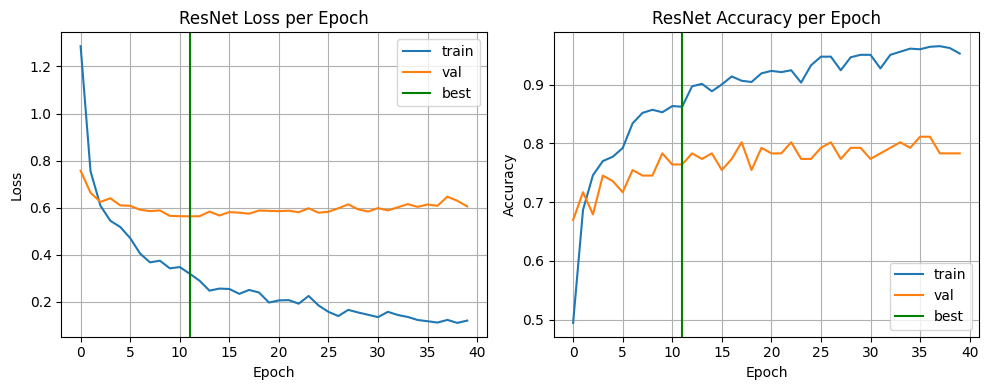

Validation Metrics:
Accuracy:  0.7830
Precision: 0.7883
Recall:    0.7830
F1 Score:  0.7853

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59        21
           1       0.81      0.78      0.79        37
           2       0.86      0.86      0.86        21
           3       0.88      0.85      0.87        27

    accuracy                           0.78       106
   macro avg       0.78      0.78      0.78       106
weighted avg       0.79      0.78      0.79       106

[[13  7  1  0]
 [ 8 29  0  0]
 [ 0  0 18  3]
 [ 2  0  2 23]]


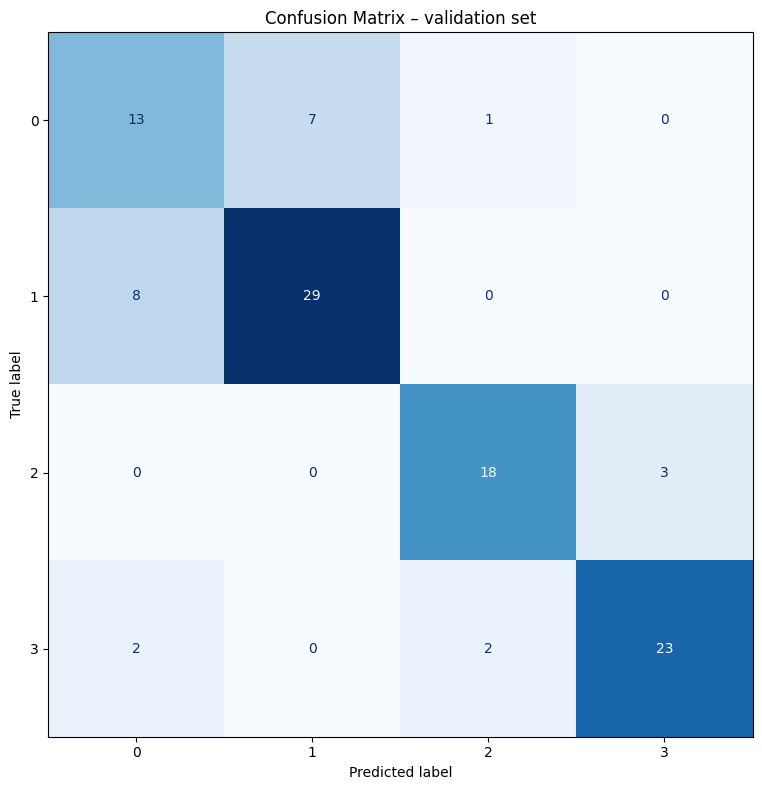

<Figure size 800x800 with 0 Axes>

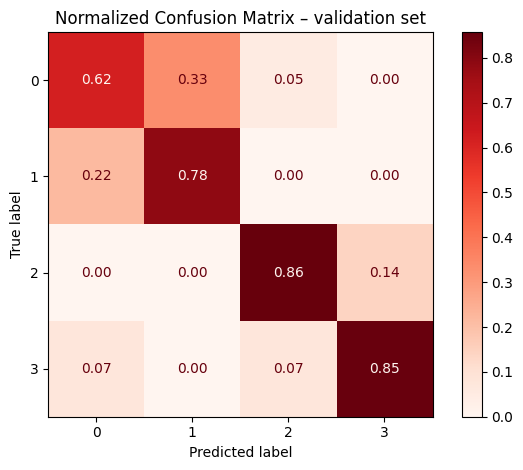

In [ ]:
#data augmentation layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.08),
    keras.layers.RandomZoom(0.08),
], name="data_augmentation")

num_classes = y_train_n.shape[1]

#base for resnet
base_resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

#need to freeze it
base_resnet.trainable = False

#head
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
#x = base_resnet(x, training=False)
x = base_resnet(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

resnet_model = keras.Model(inputs, outputs)

resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

save_model = ModelCheckpoint('best_model_10.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)

#train
history_10 = resnet_model.fit(
    x_train_resnet, y_train_n,
    validation_data=(x_val_resnet, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[save_model],
    verbose=2
)

# test evaluation
test_loss, test_acc = resnet_model.evaluate(x_test_resnet, y_test, verbose=0)

#plot loss/accuracy
best_epoch = int(np.argmin(history_10.history['val_loss']))
best_val_acc = history_10.history['val_accuracy'][best_epoch]
print(f" ResNet50 Validation Accuracy at Best Epoch ({best_epoch}): {best_val_acc*100:.2f}%")

#plots
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_10.history['loss'])
plt.plot(history_10.history['val_loss'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('ResNet Loss per Epoch')
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best'], loc='upper right'); plt.grid()

plt.subplot(1,2,2)
plt.plot(history_10.history['accuracy'])
plt.plot(history_10.history['val_accuracy'])
plt.axvline(best_epoch, color='green', linestyle='-')
plt.title('ResNet Accuracy per Epoch')
plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend(['train', 'val', 'best'], loc='lower right'); plt.grid()
plt.tight_layout(); plt.show()

#predict
y_pred_probs = resnet_model.predict(x_val_resnet, verbose=0)
y_pred_idx   = np.argmax(y_pred_probs, axis=1)
y_true_idx   = np.argmax(y_val, axis=1)

#metrics
accuracy = accuracy_score(y_true_idx, y_pred_idx)
precision = precision_score(y_true_idx, y_pred_idx, average='weighted')
recall = recall_score(y_true_idx, y_pred_idx, average='weighted')
f1 = f1_score(y_true_idx, y_pred_idx, average='weighted')

print(f"Validation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred_idx))


# confusion matrix
cm = confusion_matrix(y_true_idx, y_pred_idx)
print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=range(cm.shape[0]))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format='d')
plt.title("Confusion Matrix – validation set")
plt.tight_layout()
plt.show()

# confusion matrix with percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
disp_norm = ConfusionMatrixDisplay(cm_normalized, display_labels=range(cm.shape[0]))
disp_norm.plot(cmap="Reds", values_format='.2f')
plt.title("Normalized Confusion Matrix – validation set")
plt.tight_layout()
plt.show()